In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, StackingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from scipy.stats import mode
from tqdm import tqdm
from sklearn.datasets import make_classification

In [3]:
file_path = '/Users/michael/Thesis project/FINAL/Final_dataset_Classific.xlsx'  
# Read the specific sheet from the Excel file
dataset = pd.read_excel(file_path)

In [4]:
cols_to_drop = dataset.filter(like='Medication_').columns
dataset = dataset.drop(columns=cols_to_drop)

In [5]:
# Check for missing values, especially in the 'Outcome_numerical' column
missing_values = dataset.isnull().sum()
missing_values_percentage = (missing_values / len(dataset)) * 100

# Prepare the data frame for missing values information
missing_data_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_values_percentage})
missing_data_summary = missing_data_summary[missing_data_summary['Missing Values'] > 0]  # Filter rows with missing values
missing_data_summary.sort_values(by='Percentage', ascending=False).head(10)  # Show top 10 columns with highest missing %
# Check the remaining shape and missing values
cleaned_shape = dataset.shape
remaining_missing_values = dataset.isnull().sum().max()  # Max missing values in any column

cleaned_shape, remaining_missing_values

((470, 108), 0)

In [6]:
cluster_counts = dataset['Outcome_numerical'].value_counts()

# Define the features (X) and the target (y)
X = dataset.drop(columns=['Outcome_numerical'])
y = dataset['Outcome_numerical']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=42)  # 70% training and 30% testing
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Confirm the sizes of the datasets
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


((258, 107), (212, 107), (258,), (212,))

In [7]:
cluster_counts = dataset['Outcome_numerical'].value_counts()
cluster_counts


1    273
0    142
2     55
Name: Outcome_numerical, dtype: int64

# SMOTE model check

Original class distribution: Counter({1: 149, 0: 79, 2: 30})
SMOTE class distribution: Counter({1: 149, 0: 149, 2: 149})
                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.712264   0.737366  0.712264  0.721224
Random Forest        0.754717   0.742746  0.754717  0.743260
Gradient Boosting    0.721698   0.709456  0.721698  0.713979
SVM                  0.707547   0.719870  0.707547  0.713096
XGB                  0.702830   0.688977  0.702830  0.695023
Bagging Classifier   0.599057   0.612484  0.599057  0.601596
Decision Tree        0.603774   0.612150  0.603774  0.607604


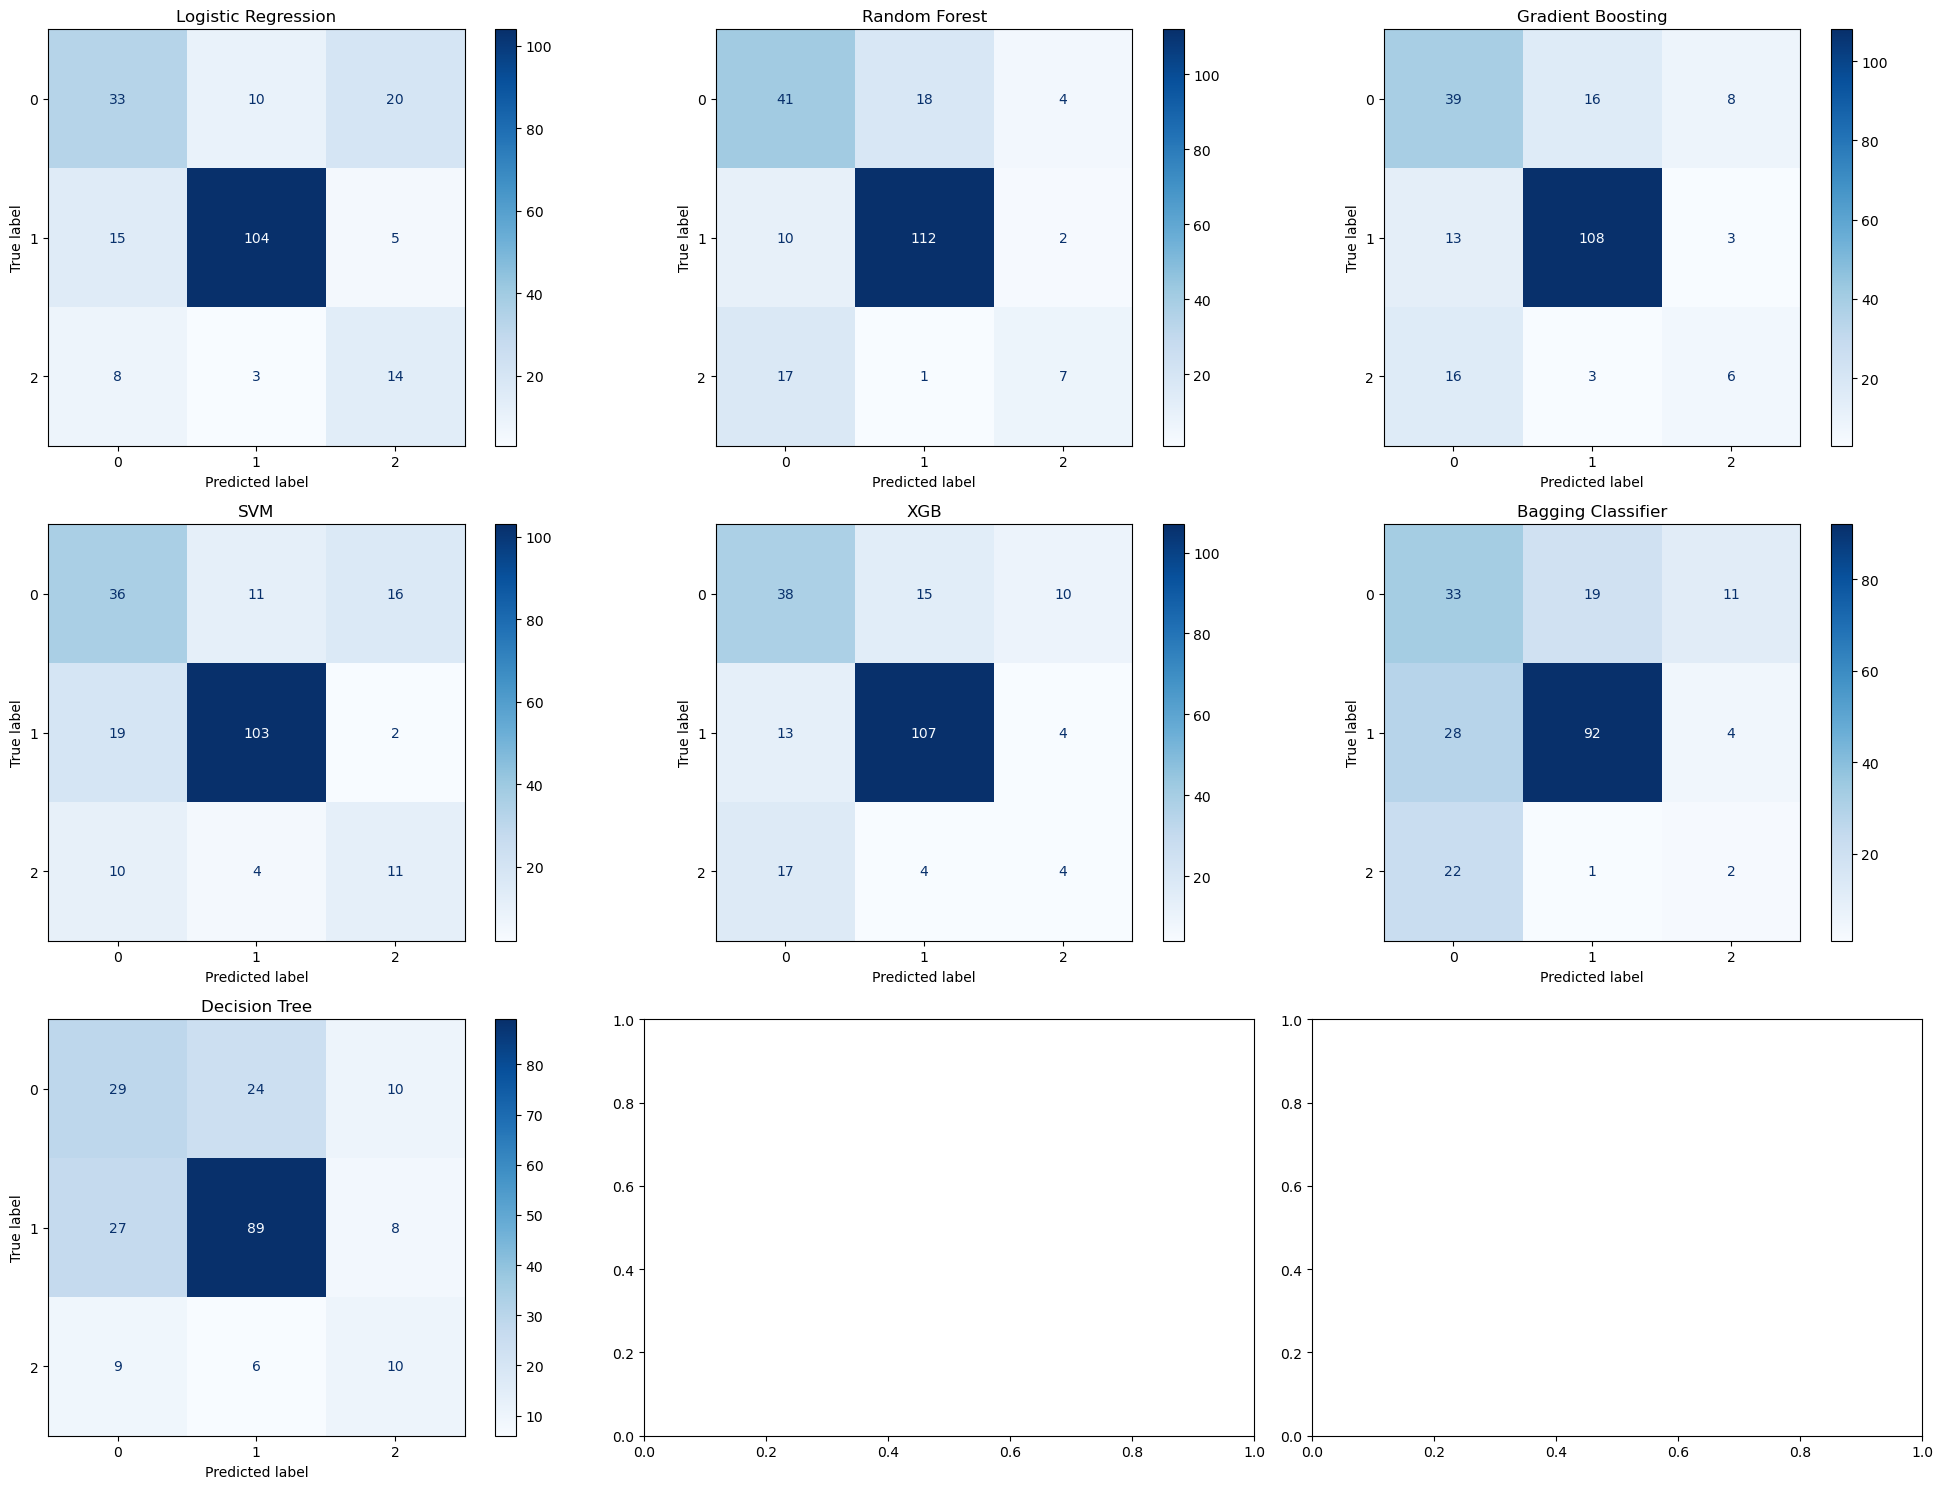

In [8]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Check the new class distribution
print(f"Original class distribution: {Counter(y_train)}")
print(f"SMOTE class distribution: {Counter(y_train_smote)}")

# Initialize all models
models = {
    'Logistic Regression': LogisticRegression(max_iter=50000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, objective='binary:logistic'),
    'Bagging Classifier': BaggingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Dictionary to hold the results and confusion matrices
results = {}
conf_matrices = {}

# Train, evaluate each model using the SMOTE-balanced data, and store confusion matrices
for name, model in models.items():
    # Train the model on the balanced dataset
    model.fit(X_train_smote, y_train_smote)
    
    # Predict on the testing set
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }
    
    # Store confusion matrix
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results).T

# Display results
print(results_df)

# Visualization of Confusion Matrices
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
for ax, (name, matrix) in zip(axes.flatten(), conf_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.title.set_text(name)
plt.tight_layout()
plt.show()


# Simple Data Models check

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.702830   0.713325  0.702830  0.707697
Random Forest        0.712264   0.680366  0.712264  0.669286
Gradient Boosting    0.754717   0.747223  0.754717  0.738900
SVM                  0.688679   0.692312  0.688679  0.687650
xgb                  0.693396   0.652779  0.693396  0.669133
Bagging Classifier   0.740566   0.729796  0.740566  0.726063
Decision Tree        0.627358   0.613006  0.627358  0.619588


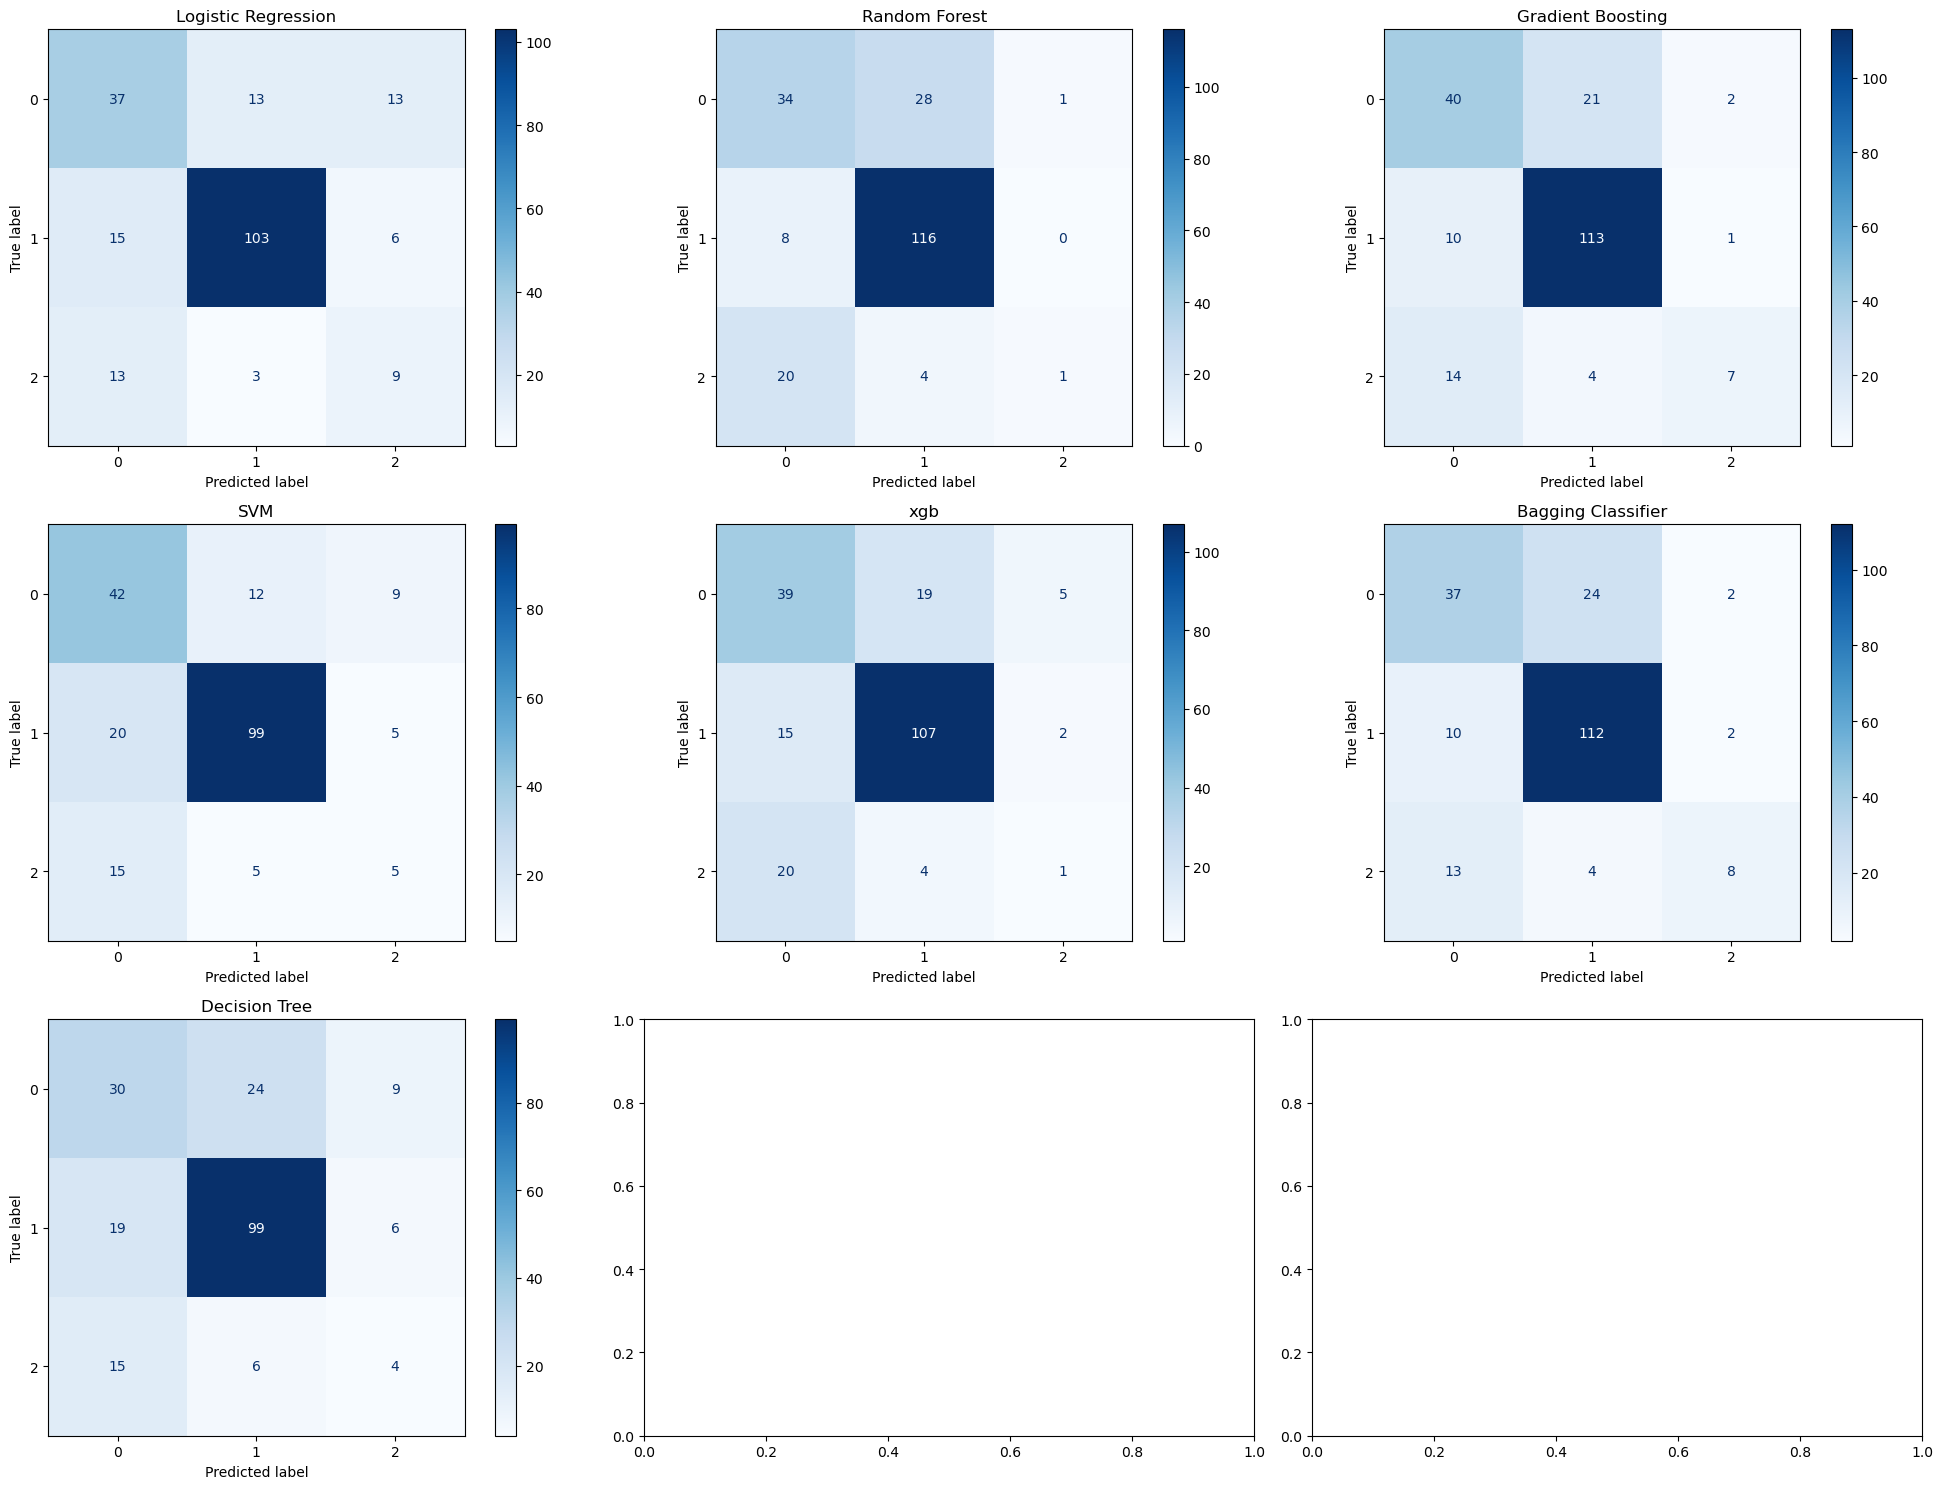

In [9]:
# Initialize all models
models = {
    'Logistic Regression': LogisticRegression(max_iter=50000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'xgb': XGBClassifier( use_label_encoder=False, eval_metric='mlogloss', random_state=42, objective='binary:logistic'),
    'Bagging Classifier': BaggingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Dictionary to hold the results and confusion matrices
results = {}
conf_matrices = {}

# Train, evaluate each model, and store confusion matrices
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the testing set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }
    
    # Store confusion matrix
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results).T

# Display results
print(results_df)

# Visualization of Confusion Matrices
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))
for ax, (name, matrix) in zip(axes.flatten(), conf_matrices.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.title.set_text(name)
plt.tight_layout()
plt.show()


# PArameters for SVM

In [85]:
# Define the parameter grid for SVM
param_grid_svm = {
    'C': [ 0.1, 1, 5, 10],  # Regularization parameter
    'kernel': ['linear'], 
}

# Initialize GridSearchCV with the SVC estimator and the defined parameter grid
svm_grid = GridSearchCV(estimator=SVC(random_state=42), 
                        param_grid=param_grid_svm, 
                        cv=10,  # Number of folds in cross-validation
                        verbose=2,  # Controls the verbosity: the higher, the more messages
                        n_jobs=-1)  # Number of jobs to run in parallel (-1 means using all processors)

# Fit the grid search to the SMOTE-balanced training data
svm_grid.fit(X_train_smote, y_train_smote)

# Extract best parameters and best score
best_params_svm = svm_grid.best_params_
best_score_svm = svm_grid.best_score_

# Output the best parameters and best score for SVM
print("Best parameters found: ", best_params_svm)
print("Best score found: ", best_score_svm)


Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END .................................C=1, kernel=linear; total time=   0.0s
[CV] END .................................C=1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END .................................C=1, k

# Optimized SVM

Accuracy: 0.7028301886792453
Precision: 0.7164798501084741
Recall: 0.7028301886792453
F1 Score: 0.7074739643011737
Accuracy: 0.7028301886792453
Precision for each class: 0.7164798501084741
Recall for each class: 0.7028301886792453
F1 Score for each class: 0.7074739643011737


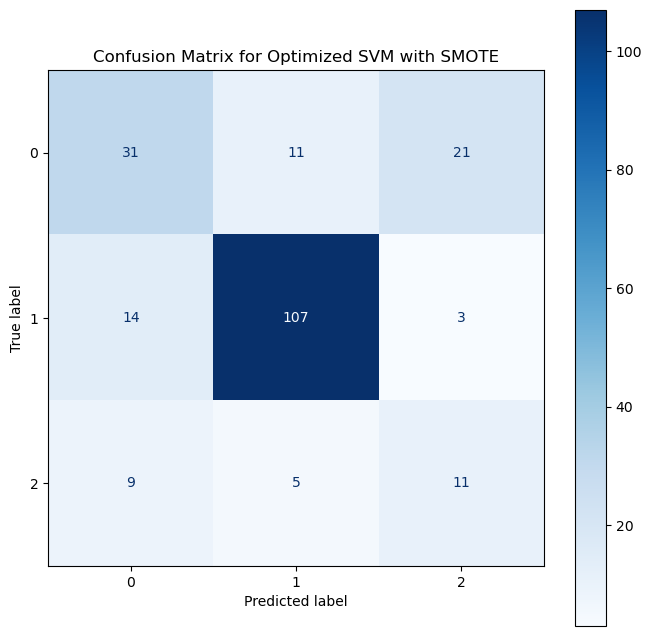

In [10]:
'''Best parameters found:  {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
Best score found:  0.9229965156794424'''
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Initialize the optimized SVM with the best parameters found by GridSearchCV
optimized_svm = SVC(
    C=0.1,  
    kernel='linear',  
    random_state=42
)

# Fit the SVM model on the SMOTE-enhanced training data
optimized_svm.fit(X_train_smote, y_train_smote)

# Make predictions on the original (unbalanced) test set
y_pred_svm = optimized_svm.predict(X_test_scaled)

# Calculate evaluation metrics
optimized_accuracy_svm = accuracy_score(y_test, y_pred_svm)
optimized_precision_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=0)
optimized_recall_svm = recall_score(y_test, y_pred_svm, average='weighted', zero_division=0)
optimized_f1_svm = f1_score(y_test, y_pred_svm, average='weighted', zero_division=0)

# Calculate and display the confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print(f"Accuracy: {optimized_accuracy_svm}")
print(f"Precision: {optimized_precision_svm}")
print(f"Recall: {optimized_recall_svm}")
print(f"F1 Score: {optimized_f1_svm}")


# Print the metrics for each class
print(f"Accuracy: {optimized_accuracy_svm}")
print("Precision for each class:", optimized_precision_svm)
print("Recall for each class:", optimized_recall_svm)
print("F1 Score for each class:", optimized_f1_svm)

# Calculate and display the confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as necessary
disp_svm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm)
disp_svm.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized SVM with SMOTE')
plt.show()




Accuracy: 0.7028301886792453
Precision for each class: [0.57407407 0.8699187  0.31428571]
Recall for each class: [0.49206349 0.86290323 0.44      ]
F1 Score for each class: [0.52991453 0.86639676 0.36666667]


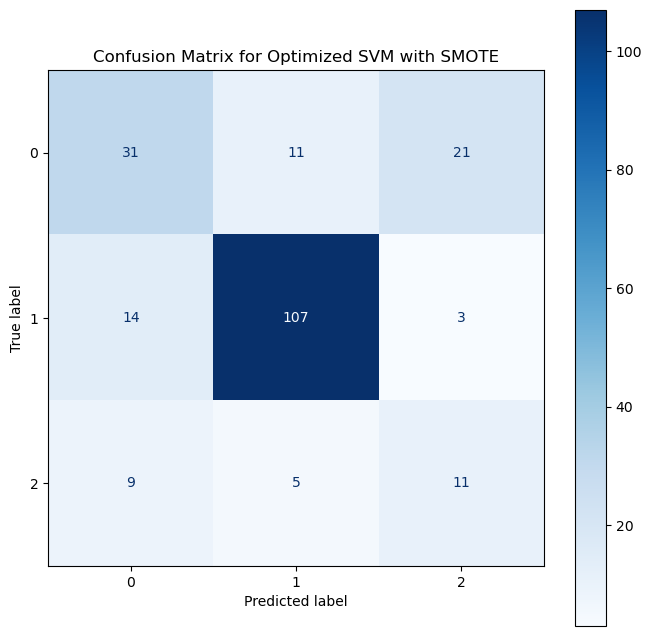

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Assuming X_train_smote, y_train_smote, X_test_scaled, and y_test are already defined

# Initialize the optimized SVM with the best parameters found by GridSearchCV
optimized_svm = SVC(
    C=0.1,  # Update based on best parameters found
    kernel='linear',  # Update based on best parameters found
    random_state=42
)

# Fit the SVM model on the SMOTE-enhanced training data
optimized_svm.fit(X_train_smote, y_train_smote)

# Make predictions on the original (unbalanced) test set
y_pred_svm = optimized_svm.predict(X_test_scaled)

# Calculate evaluation metrics for each class
optimized_accuracy_svm = accuracy_score(y_test, y_pred_svm)
optimized_precision_svm = precision_score(y_test, y_pred_svm, average=None, zero_division=0)  # Scores for each class
optimized_recall_svm = recall_score(y_test, y_pred_svm, average=None, zero_division=0)  # Scores for each class
optimized_f1_svm = f1_score(y_test, y_pred_svm, average=None, zero_division=0)  # Scores for each class

# Print the metrics for each class
print(f"Accuracy: {optimized_accuracy_svm}")
print("Precision for each class:", optimized_precision_svm)
print("Recall for each class:", optimized_recall_svm)
print("F1 Score for each class:", optimized_f1_svm)

# Calculate and display the confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as necessary
disp_svm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm)
disp_svm.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized SVM with SMOTE')
plt.show()


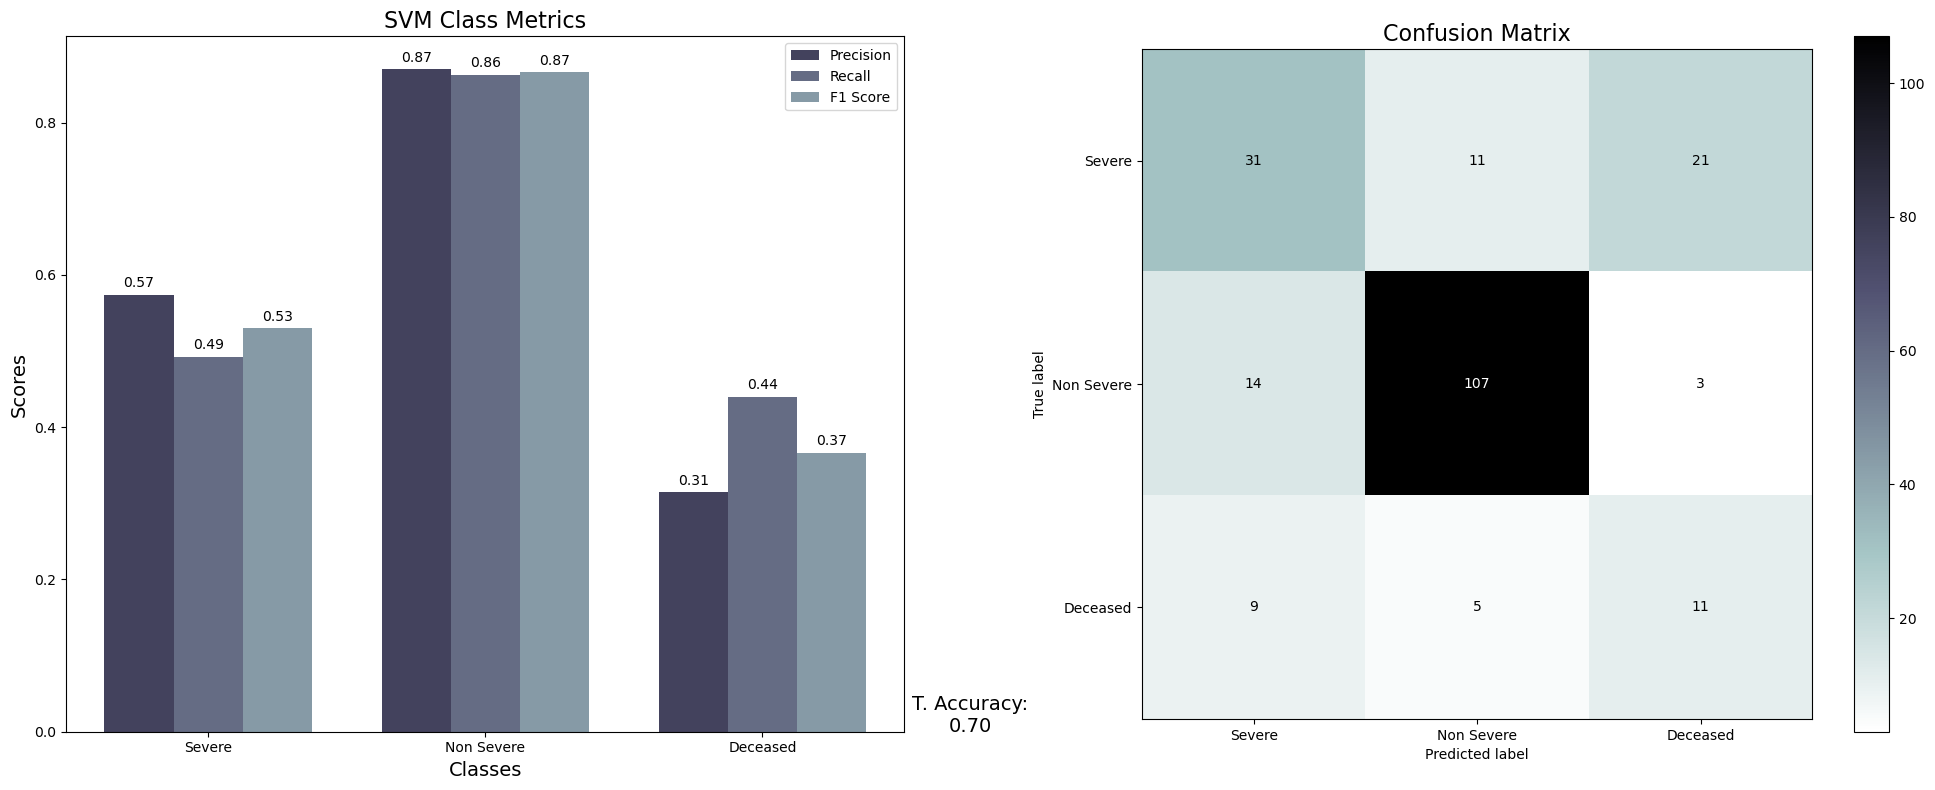

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming class_labels and metrics are already defined

# Setting up the subplot layout
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Two plots side by side

# Metrics visualization (on the left)
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3))  # Generate bone palette for three metrics

class_labels = ['Severe', 'Non Severe', 'Deceased']

# Plotting precision, recall, and F1-score for each class
bar_width = 0.25
index = np.arange(len(class_labels))
axes[0].bar(index, optimized_precision_svm, bar_width, color=bone_palette[0], label='Precision')
axes[0].bar(index + bar_width, optimized_recall_svm, bar_width, color=bone_palette[1], label='Recall')
axes[0].bar(index + 2 * bar_width, optimized_f1_svm, bar_width, color=bone_palette[2], label='F1 Score')

# Adding details to the metrics plot
axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Scores', fontsize=14)
axes[0].set_title('SVM Class Metrics', fontsize=16)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# Annotate the bars with the actual values and add overall accuracy
for i in range(len(class_labels)):
    axes[0].text(i, optimized_precision_svm[i] + 0.01, f'{optimized_precision_svm[i]:.2f}', ha='center')
    axes[0].text(i + bar_width, optimized_recall_svm[i] + 0.01, f'{optimized_recall_svm[i]:.2f}', ha='center')
    axes[0].text(i + 2 * bar_width, optimized_f1_svm[i] + 0.01, f'{optimized_f1_svm[i]:.2f}', ha='center')

# Adding the overall accuracy
axes[0].text(len(class_labels), 0, f'T. Accuracy:\n{optimized_accuracy_svm:.2f}', fontsize=14, ha='center')

# Confusion matrix visualization (on the right)
conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix_svm, display_labels=class_labels)
conf_matrix_disp.plot(cmap=plt.cm.bone_r, ax=axes[1], colorbar=True)
axes[1].set_title('Confusion Matrix', fontsize=16)

plt.tight_layout()
plt.show()


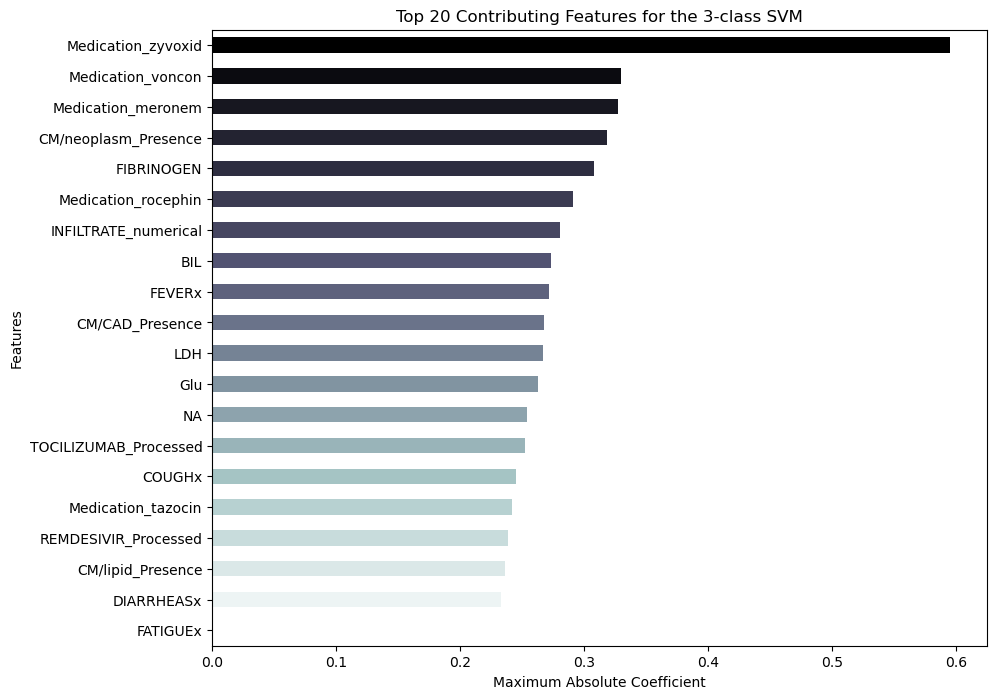

In [95]:
#Get the coefficients for the linear SVM
# The shape of coef_ is (n_classes, n_features)
coefficients = optimized_svm.coef_

# Create a DataFrame for easier manipulation
feature_names = X_train.columns
coef_df = pd.DataFrame(coefficients, index=['Class1', 'Class2', 'Class3'], columns=feature_names)

# Aggregate the importance by taking the maximum of the absolute values across classes for each feature
feature_importance = coef_df.abs().max(axis=0)

# Sort features by their importance
sorted_features = feature_importance.sort_values(ascending=False)

# Select the top 20 features
top20_features = sorted_features[:20]

# Plotting
plt.figure(figsize=(10, 8))
bone_colors = plt.cm.bone(np.linspace(0, 1, 20))
top20_features.plot(kind='barh', color=bone_colors)
plt.title('Top 20 Contributing Features for the 3-class SVM')
plt.xlabel('Maximum Absolute Coefficient')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


# Parametrs for Grad Boosting

In [18]:
# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.2, 0.25],
    'max_depth': [4, 5],
    'min_samples_split': [ 2, 3],
    'min_samples_leaf': [2, 3],
    'subsample': [0.6, 0.8]
}

# Initialize the GridSearchCV object with F1 scoring
gb_grid = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), 
                       param_grid=param_grid_gb, 
                       cv=10, 
                       verbose=2, 
                       n_jobs=-1,
                       scoring=make_scorer(f1_score, average='weighted'))  # Use weighted F1 score

# Fit the grid search to the data
gb_grid.fit(X_train_smote, y_train_smote)

# Extract best parameters and best score
best_params_gb = gb_grid.best_params_
best_score_gb = gb_grid.best_score_

# Output the best parameters and best F1 score
(best_params_gb, best_score_gb)


Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV] END learning_rate=0.2, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=150, subsample=0.6; total time=   2.0s
[CV] END learning_rate=0.2, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=150, subsample=0.6; total time=   2.0s
[CV] END learning_rate=0.2, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=150, subsample=0.6; total time=   2.0s
[CV] END learning_rate=0.2, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=150, subsample=0.6; total time=   2.2s
[CV] END learning_rate=0.2, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=150, subsample=0.6; total time=   2.1s
[CV] END learning_rate=0.2, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=150, subsample=0.6; total time=   2.2s
[CV] END learning_rate=0.2, max_depth=4, min_samples_leaf=2, min_samples_split=2, n_estimators=150, subsample=0.6; total time=   2.1s

({'learning_rate': 0.2,
  'max_depth': 5,
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'n_estimators': 150,
  'subsample': 0.6},
 0.9369759376996993)

# Optimized Grad Boost

Accuracy: 0.7311320754716981
Precision: 0.7139619403770349
Recall: 0.7311320754716981
F1 Score: 0.7177412388286926


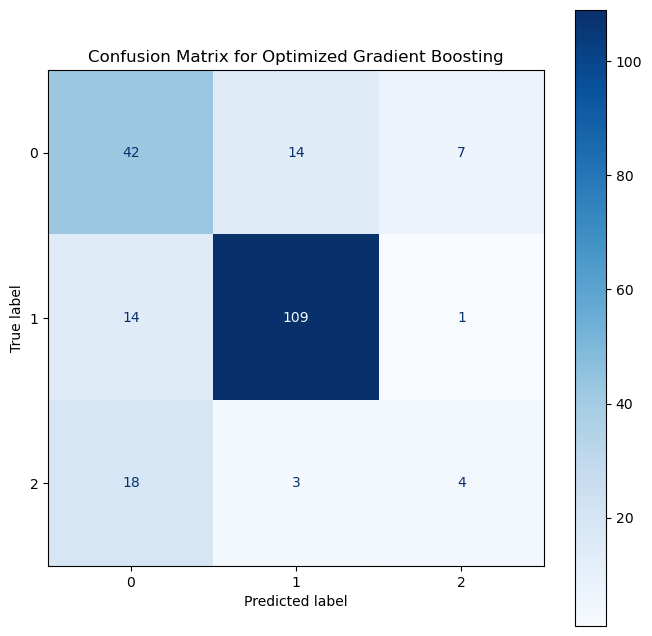

In [30]:
'''({'learning_rate': 0.25,
  'max_depth': 5,
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'n_estimators': 200,
  'subsample': 0.8},
 0.9325605907898392)'''


# Correctly initialized Gradient Boosting model with the best parameters
optimized_gb = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=2,
    min_samples_leaf=10,
    min_samples_split=2,
    n_estimators=400,
    subsample=0.8,
    random_state=42
)

# Fit the model to the training data
optimized_gb.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred_gb = optimized_gb.predict(X_test_scaled)

# Calculate metrics
optimized_accuracy_gb = accuracy_score(y_test, y_pred_gb)
optimized_precision_gb = precision_score(y_test, y_pred_gb, average='weighted')
optimized_recall_gb = recall_score(y_test, y_pred_gb, average='weighted')
optimized_f1_gb = f1_score(y_test, y_pred_gb, average='weighted')

# Calculate and display the confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

print(f"Accuracy: {optimized_accuracy_gb}")
print(f"Precision: {optimized_precision_gb}")
print(f"Recall: {optimized_recall_gb}")
print(f"F1 Score: {optimized_f1_gb}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp_gb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gb)
disp_gb.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized Gradient Boosting')
plt.show()


Accuracy: 0.7311320754716981
Precision for each class: [0.56756757 0.86507937 0.33333333]
Recall for each class: [0.66666667 0.87903226 0.16      ]
F1 Score for each class: [0.61313869 0.872      0.21621622]


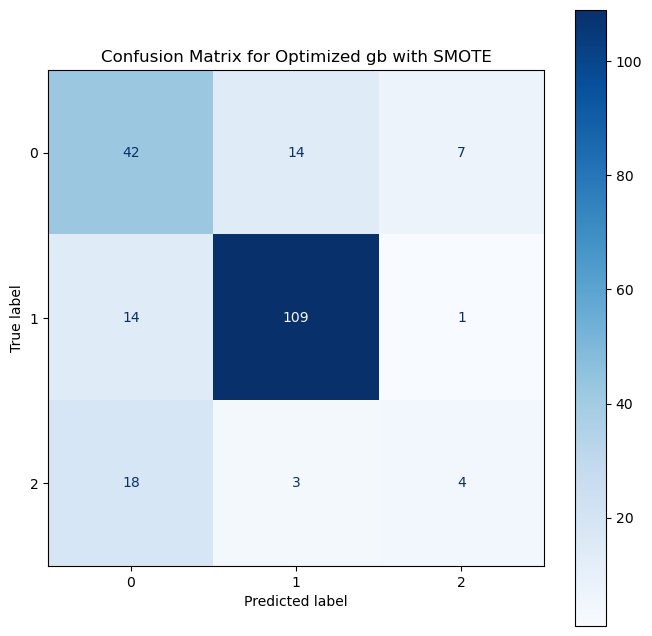

In [31]:

# Calculate evaluation metrics for each class
optimized_accuracy_gb = accuracy_score(y_test, y_pred_gb)
optimized_precision_gb = precision_score(y_test, y_pred_gb, average=None, zero_division=0)  # Scores for each class
optimized_recall_gb = recall_score(y_test, y_pred_gb, average=None, zero_division=0)  # Scores for each class
optimized_f1_gb = f1_score(y_test, y_pred_gb, average=None, zero_division=0)  # Scores for each class

# Print the metrics for each class
print(f"Accuracy: {optimized_accuracy_gb}")
print("Precision for each class:", optimized_precision_gb)
print("Recall for each class:", optimized_recall_gb)
print("F1 Score for each class:", optimized_f1_gb)

# Calculate and display the confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as necessary
disp_gb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gb)
disp_gb.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized gb with SMOTE')
plt.show()


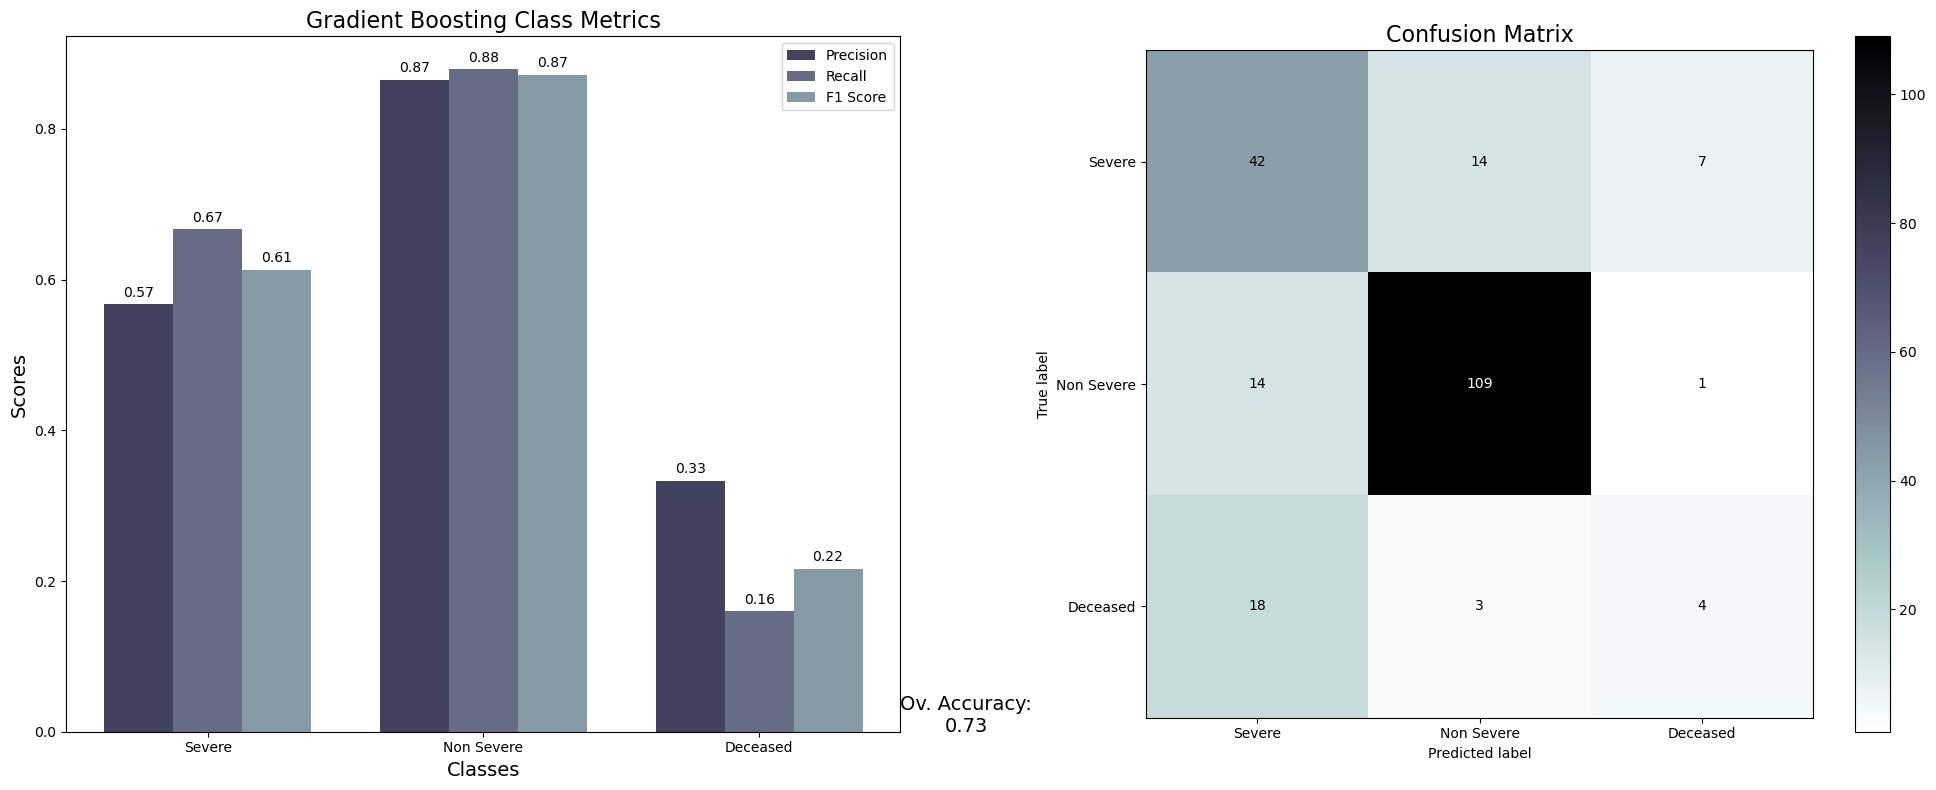

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming class_labels and GB metrics are already defined

# Setting up the subplot layout
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Two plots side by side
class_labels = ['Severe', 'Non Severe', 'Deceased']
# Metrics visualization (on the left)
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3))  # Generate bone palette for three metrics

# Plotting precision, recall, and F1-score for each class using GB metrics
bar_width = 0.25
index = np.arange(len(class_labels))
axes[0].bar(index, optimized_precision_gb, bar_width, color=bone_palette[0], label='Precision')
axes[0].bar(index + bar_width, optimized_recall_gb, bar_width, color=bone_palette[1], label='Recall')
axes[0].bar(index + 2 * bar_width, optimized_f1_gb, bar_width, color=bone_palette[2], label='F1 Score')

# Adding details to the GB metrics plot
axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Scores', fontsize=14)
axes[0].set_title('Gradient Boosting Class Metrics', fontsize=16)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# Annotate the bars with the actual values and add overall accuracy for GB
for i in index:
    axes[0].text(i, optimized_precision_gb[i] + 0.01, f'{optimized_precision_gb[i]:.2f}', ha='center')
    axes[0].text(i + bar_width, optimized_recall_gb[i] + 0.01, f'{optimized_recall_gb[i]:.2f}', ha='center')
    axes[0].text(i + 2 * bar_width, optimized_f1_gb[i] + 0.01, f'{optimized_f1_gb[i]:.2f}', ha='center')

# Adding the overall accuracy for GB
axes[0].text(len(class_labels), 0, f'Ov. Accuracy:\n{optimized_accuracy_gb:.2f}', fontsize=14, ha='center')

# Confusion matrix visualization (on the right) for GB
conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix_gb, display_labels=class_labels)
conf_matrix_disp.plot(cmap=plt.cm.bone_r, ax=axes[1], colorbar=True)
axes[1].set_title('Confusion Matrix', fontsize=16)

plt.tight_layout()
plt.show()


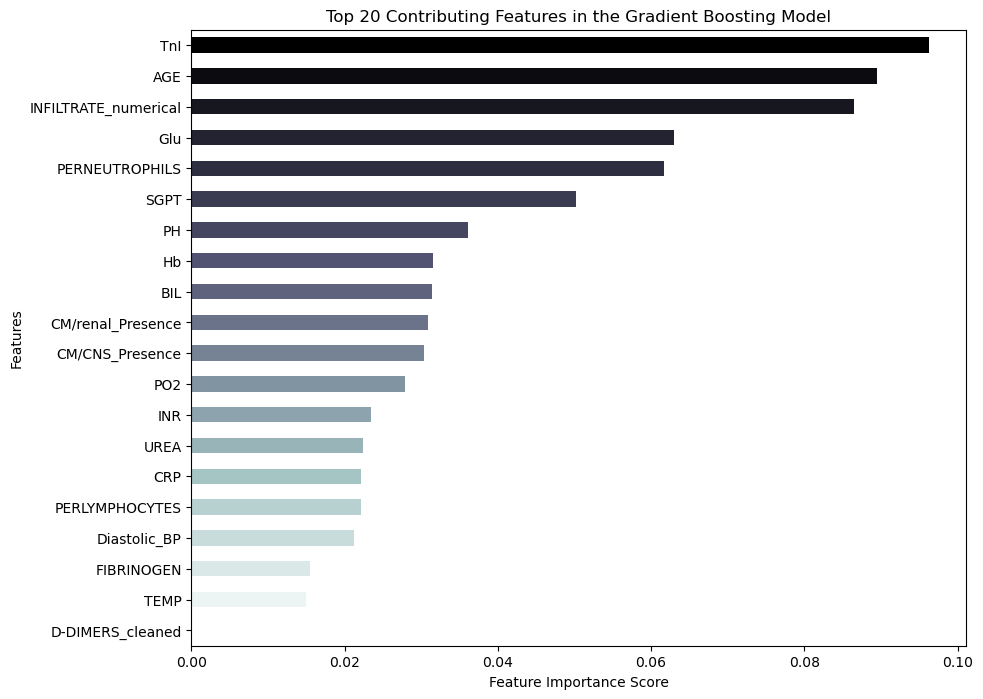

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Access feature importance from the model
feature_importances = optimized_gb.feature_importances_

# Create a pandas series to hold the feature importances and their corresponding feature names
importances = pd.Series(feature_importances, index=X.columns)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)

# Select the top 20 features
top20_importances = sorted_importances[:20]

# Plotting
plt.figure(figsize=(10, 8))
bone_colors = plt.cm.bone(np.linspace(0, 1, 20))
top20_importances.plot(kind='barh', color=bone_colors)
plt.title('Top 20 Contributing Features in the Gradient Boosting Model')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()



In [86]:
import pandas as pd
import matplotlib.pyplot as plt

 Access feature importance from the model
feature_importances = optimized_gb.feature_importances_

# Create a pandas series to hold the feature importances and their corresponding feature names
importances = pd.Series(feature_importances, index=X.columns)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)

# Select the top 20 features
top20_importances = sorted_importances[:20]
# Plotting using the 'bone' color palette
plt.figure(figsize=(10, 8))
bone_colors = plt.cm.bone(np.linspace(0, 1, 20))  # Generate 20 color shades from the 'bone' palette
top20_features.plot(kind='barh', color=bone_colors)
plt.title('Top 20 Important Features for SVM')
plt.xlabel('Maximum Absolute Coefficient')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


IndentationError: unexpected indent (646039380.py, line 4)

# Parameters for RF

In [18]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3], 
}

# Initialize the GridSearchCV object for Random Forest
rf_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                       param_grid=param_grid_rf,
                       cv=10,
                       verbose=2,
                       n_jobs=-1,
                       scoring=make_scorer(f1_score, average='weighted'))

# Fit the grid search to the data
rf_grid.fit(X_train_smote, y_train_smote)

# Extract best parameters and best score for Random Forest
best_params_rf = rf_grid.best_params_
best_score_rf = rf_grid.best_score_
print("Best parameters for Random Forest:", best_params_rf)
print("Best weighted F1 score for Random Forest:", best_score_rf)


Fitting 10 folds for each of 81 candidates, totalling 810 fits
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_lea

# Optimized RF

Accuracy: 0.7547169811320755
Precision: 0.7427457535601794
Recall: 0.7547169811320755
F1 Score: 0.7432600519607769


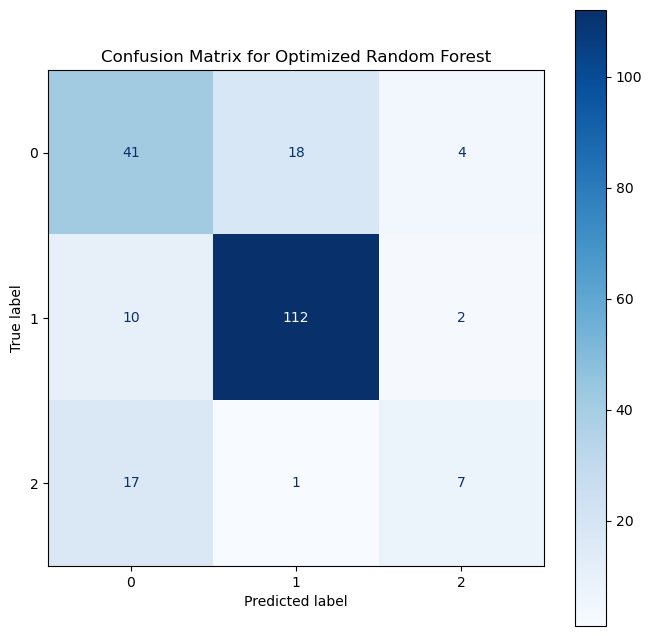

In [34]:
"""{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 150}
Best weighted F1 score for Random Forest: 0.9528361347663281"""
# Correctly initialized Random Forest model with the best parameters
optimized_rf = RandomForestClassifier(      
    random_state=42
)

# Fit the model to the training data
optimized_rf.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred_rf = optimized_rf.predict(X_test_scaled)

# Calculate metrics
optimized_accuracy_rf = accuracy_score(y_test, y_pred_rf)
optimized_precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
optimized_recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
optimized_f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print(f"Accuracy: {optimized_accuracy_rf}")
print(f"Precision: {optimized_precision_rf}")
print(f"Recall: {optimized_recall_rf}")
print(f"F1 Score: {optimized_f1_rf}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf)
disp_rf.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized Random Forest')
plt.show()

Accuracy: 0.7547169811320755
Precision for each class: [0.60294118 0.85496183 0.53846154]
Recall for each class: [0.65079365 0.90322581 0.28      ]
F1 Score for each class: [0.6259542  0.87843137 0.36842105]


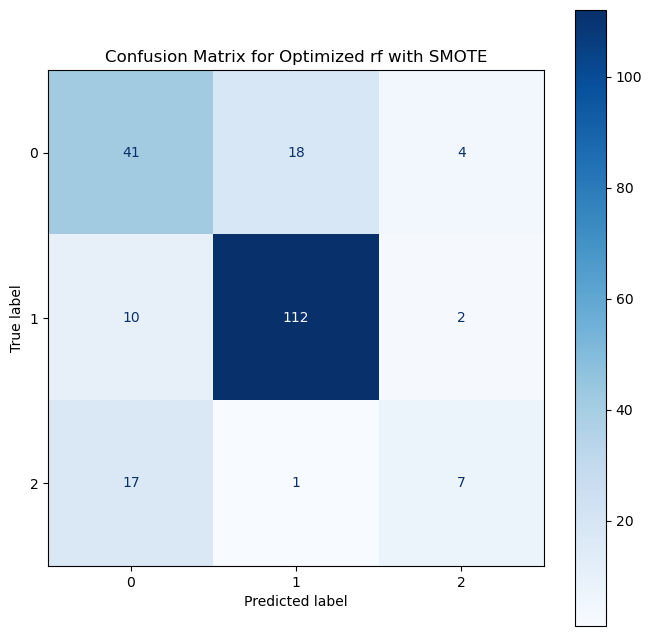

In [35]:

# Calculate evaluation metrics for each class
optimized_accuracy_rf = accuracy_score(y_test, y_pred_rf)
optimized_precision_rf = precision_score(y_test, y_pred_rf, average=None, zero_division=0)  # Scores for each class
optimized_recall_rf = recall_score(y_test, y_pred_rf, average=None, zero_division=0)  # Scores for each class
optimized_f1_rf = f1_score(y_test, y_pred_rf, average=None, zero_division=0)  # Scores for each class

# Print the metrics for each class
print(f"Accuracy: {optimized_accuracy_rf}")
print("Precision for each class:", optimized_precision_rf)
print("Recall for each class:", optimized_recall_rf)
print("F1 Score for each class:", optimized_f1_rf)

# Calculate and display the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as necessary
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf)
disp_rf.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized rf with SMOTE')
plt.show()


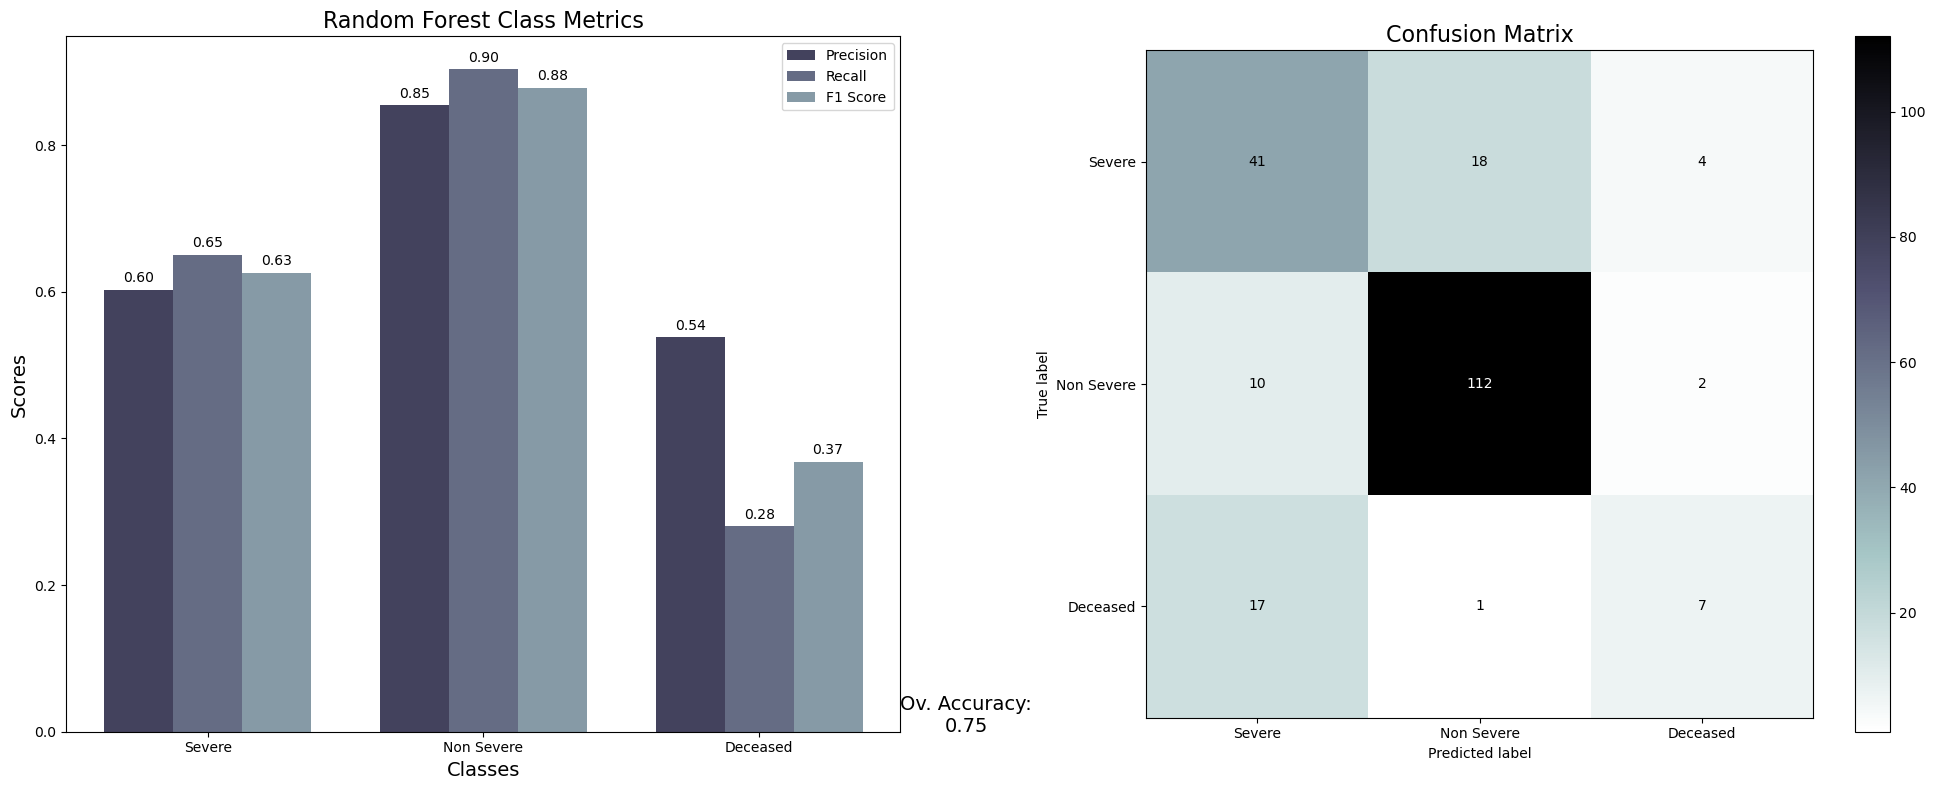

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming class_labels and rf metrics are already defined

# Setting up the subplot layout
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Two plots side by side
class_labels = ['Severe', 'Non Severe', 'Deceased']
# Metrics visualization (on the left)
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3))  # Generate bone palette for three metrics

# Plotting precision, recall, and F1-score for each class using rf metrics
bar_width = 0.25
index = np.arange(len(class_labels))
axes[0].bar(index, optimized_precision_rf, bar_width, color=bone_palette[0], label='Precision')
axes[0].bar(index + bar_width, optimized_recall_rf, bar_width, color=bone_palette[1], label='Recall')
axes[0].bar(index + 2 * bar_width, optimized_f1_rf, bar_width, color=bone_palette[2], label='F1 Score')

# Adding details to the rf metrics plot
axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Scores', fontsize=14)
axes[0].set_title('Random Forest Class Metrics', fontsize=16)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# Annotate the bars with the actual values and add overall accuracy for rf
for i in index:
    axes[0].text(i, optimized_precision_rf[i] + 0.01, f'{optimized_precision_rf[i]:.2f}', ha='center')
    axes[0].text(i + bar_width, optimized_recall_rf[i] + 0.01, f'{optimized_recall_rf[i]:.2f}', ha='center')
    axes[0].text(i + 2 * bar_width, optimized_f1_rf[i] + 0.01, f'{optimized_f1_rf[i]:.2f}', ha='center')

# Adding the overall accuracy for rf
axes[0].text(len(class_labels), 0, f'Ov. Accuracy:\n{optimized_accuracy_rf:.2f}', fontsize=14, ha='center')

# Confusion matrix visualization (on the right) for rf
conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix_rf, display_labels=class_labels)
conf_matrix_disp.plot(cmap=plt.cm.bone_r, ax=axes[1], colorbar=True)
axes[1].set_title('Confusion Matrix', fontsize=16)

plt.tight_layout()
plt.show()


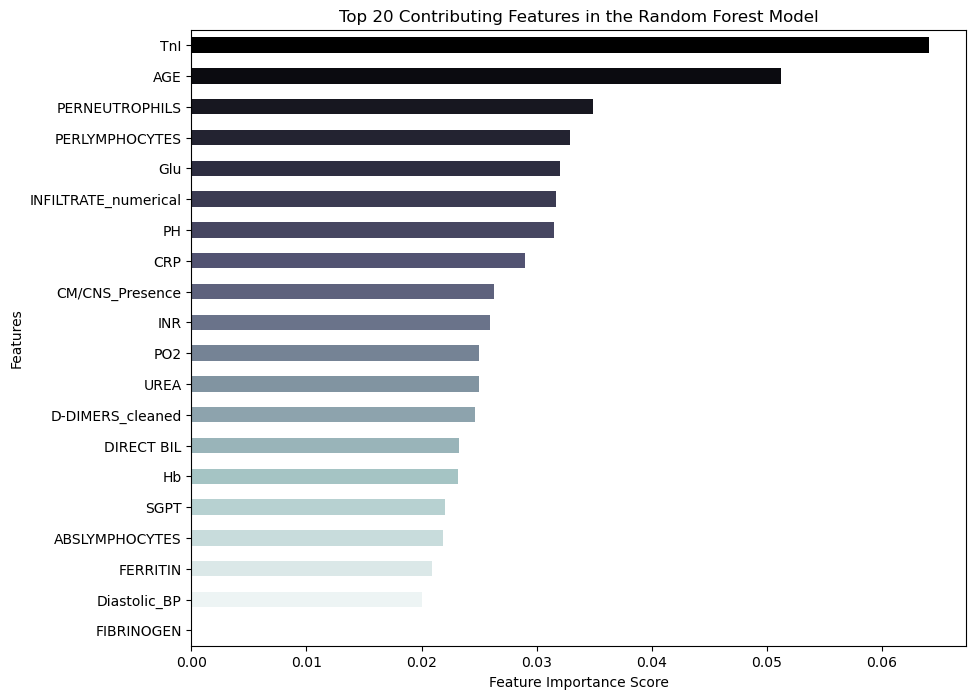

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Access feature importance from the model
feature_importances = optimized_rf.feature_importances_

# Create a pandas series to hold the feature importances and their corresponding feature names
importances = pd.Series(feature_importances, index=X.columns)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)

# Select the top 20 features
top20_importances = sorted_importances[:20]

# Plotting
plt.figure(figsize=(10, 8))
bone_colors = plt.cm.bone(np.linspace(0, 1, 20))
top20_importances.plot(kind='barh', color=bone_colors)
plt.title('Top 20 Contributing Features in the Random Forest Model')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


# Parameters for XGBoost

In [ ]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the GridSearchCV object for XGBoost
xgb_grid = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                        param_grid=param_grid_xgb,
                        cv=10,
                        verbose=2,
                        n_jobs=-1,
                        scoring=make_scorer(f1_score, average='weighted'))

# Fit the grid search to the data
xgb_grid.fit(X_train_smote, y_train_smote)

# Extract best parameters and best score for XGBoost
best_params_xgb = xgb_grid.best_params_
best_score_xgb = xgb_grid.best_score_
print("Best parameters for XGBoost:", best_params_xgb)
print("Best weighted F1 score for XGBoost:", best_score_xgb)


Fitting 10 folds for each of 729 candidates, totalling 7290 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; to

# Optimized XGBoost

Accuracy: 0.7311320754716981
Precision: 0.7199831279191786
Recall: 0.7311320754716981
F1 Score: 0.724721932231145


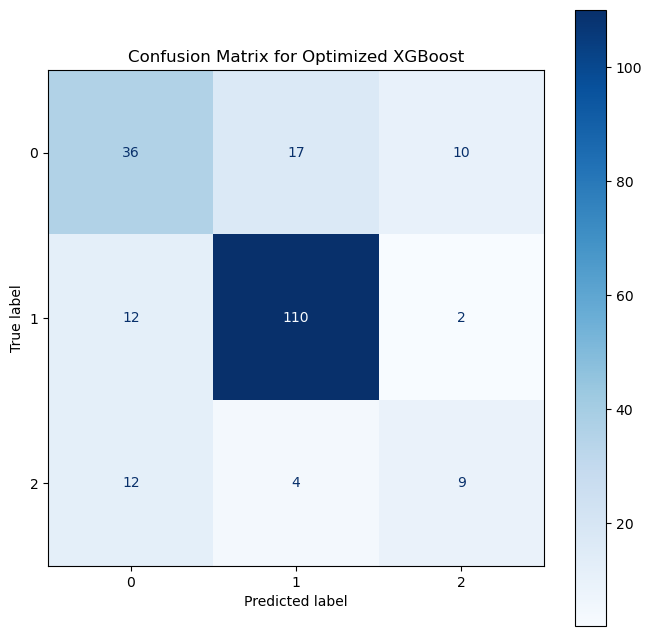

In [38]:
'''Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.8}
Best weighted F1 score for XGBoost: 0.9391421882985835'''
# Correctly initialized XGBoost model with the best parameters
optimized_xgb = XGBClassifier(
    learning_rate=0.1,    
    n_estimators=100,     
    max_depth=3,          
    min_child_weight=1,   
    subsample=0.8,        
    colsample_bytree=0.6, 
    use_label_encoder=False,  
)

# Fit the model to the training data
optimized_xgb.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred_xgb = optimized_xgb.predict(X_test_scaled)

# Calculate metrics
optimized_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
optimized_precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
optimized_recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
optimized_f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

# Calculate and display the confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print(f"Accuracy: {optimized_accuracy_xgb}")
print(f"Precision: {optimized_precision_xgb}")
print(f"Recall: {optimized_recall_xgb}")
print(f"F1 Score: {optimized_f1_xgb}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb)
disp_xgb.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized XGBoost')
plt.show()


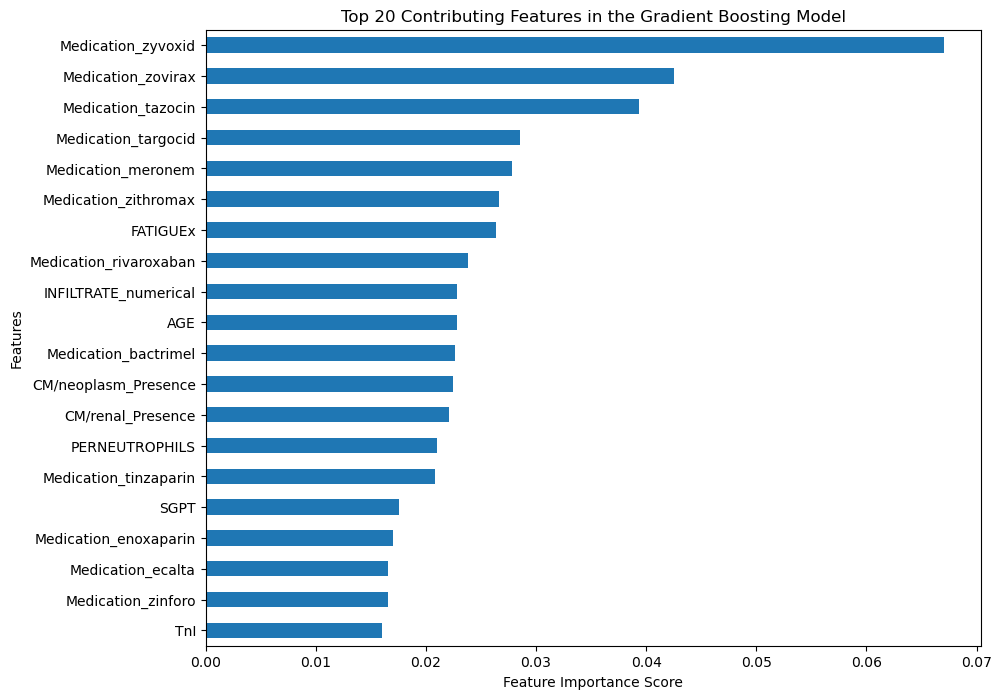

In [161]:
import matplotlib.pyplot as plt
import numpy as np

# Access feature importance from the model
feature_importances = optimized_xgb.feature_importances_

# Create a pandas series to hold the feature importances and their corresponding feature names
importances = pd.Series(feature_importances, index=X.columns)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)

# Select the top 20 features
top20_importances = sorted_importances[:20]

# Plotting
plt.figure(figsize=(10, 8))
top20_importances.plot(kind='barh')
plt.title('Top 20 Contributing Features in the Gradient Boosting Model')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


Accuracy: 0.7311320754716981
Precision for each class: [0.6        0.83969466 0.42857143]
Recall for each class: [0.57142857 0.88709677 0.36      ]
F1 Score for each class: [0.58536585 0.8627451  0.39130435]


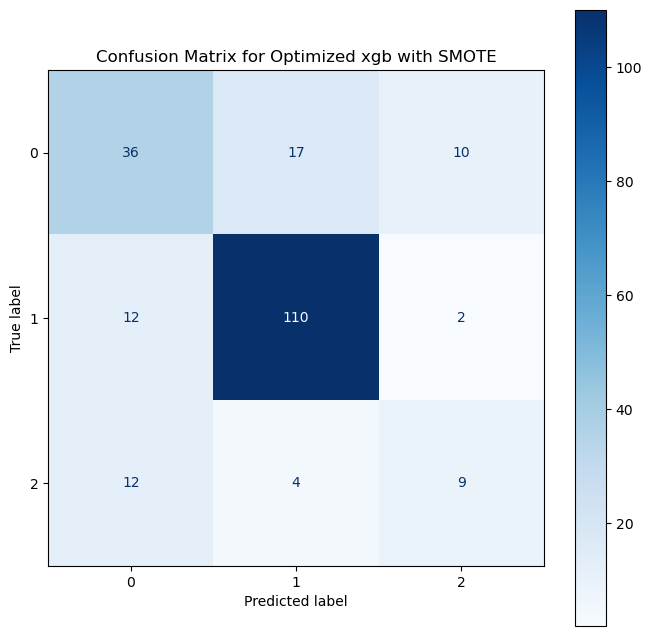

In [39]:
# Calculate evaluation metrics for each class
optimized_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
optimized_precision_xgb = precision_score(y_test, y_pred_xgb, average=None, zero_division=0)  # Scores for each class
optimized_recall_xgb = recall_score(y_test, y_pred_xgb, average=None, zero_division=0)  # Scores for each class
optimized_f1_xgb = f1_score(y_test, y_pred_xgb, average=None, zero_division=0)  # Scores for each class

# Print the metrics for each class
print(f"Accuracy: {optimized_accuracy_xgb}")
print("Precision for each class:", optimized_precision_xgb)
print("Recall for each class:", optimized_recall_xgb)
print("F1 Score for each class:", optimized_f1_xgb)

# Calculate and display the confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as necessary
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb)
disp_xgb.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized xgb with SMOTE')
plt.show()


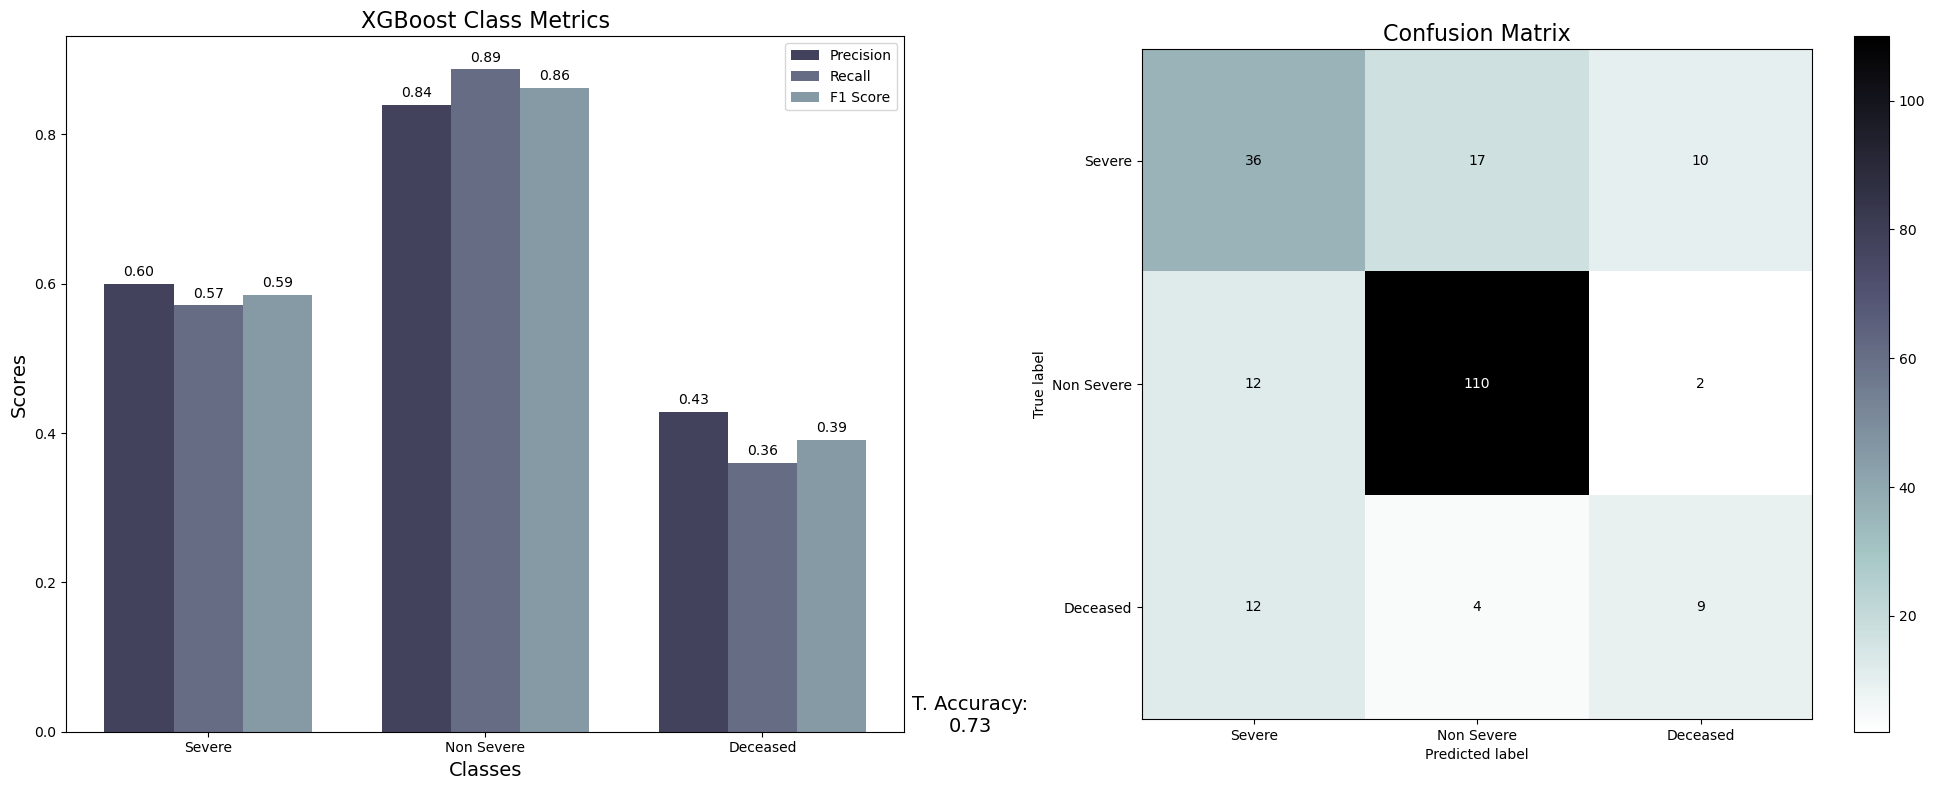

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming class_labels and xgb metrics are already defined

# Setting up the subplot layout
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Two plots side by side
class_labels = ['Severe', 'Non Severe', 'Deceased']
# Metrics visualization (on the left)
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3))  # Generate bone palette for three metrics

# Plotting precision, recall, and F1-score for each class using xgb metrics
bar_width = 0.25
index = np.arange(len(class_labels))
axes[0].bar(index, optimized_precision_xgb, bar_width, color=bone_palette[0], label='Precision')
axes[0].bar(index + bar_width, optimized_recall_xgb, bar_width, color=bone_palette[1], label='Recall')
axes[0].bar(index + 2 * bar_width, optimized_f1_xgb, bar_width, color=bone_palette[2], label='F1 Score')

# Adding details to the xgb metrics plot
axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Scores', fontsize=14)
axes[0].set_title('XGBoost Class Metrics', fontsize=16)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# Annotate the bars with the actual values and add overall accuracy for xgb
for i in index:
    axes[0].text(i, optimized_precision_xgb[i] + 0.01, f'{optimized_precision_xgb[i]:.2f}', ha='center')
    axes[0].text(i + bar_width, optimized_recall_xgb[i] + 0.01, f'{optimized_recall_xgb[i]:.2f}', ha='center')
    axes[0].text(i + 2 * bar_width, optimized_f1_xgb[i] + 0.01, f'{optimized_f1_xgb[i]:.2f}', ha='center')

# Adding the overall accuracy for xgb
axes[0].text(len(class_labels), 0, f'T. Accuracy:\n{optimized_accuracy_xgb:.2f}', fontsize=14, ha='center')

# Confusion matrix visualization (on the right) for xgb
conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix_xgb, display_labels=class_labels)
conf_matrix_disp.plot(cmap=plt.cm.bone_r, ax=axes[1], colorbar=True)
axes[1].set_title('Confusion Matrix', fontsize=16)

plt.tight_layout()
plt.show()


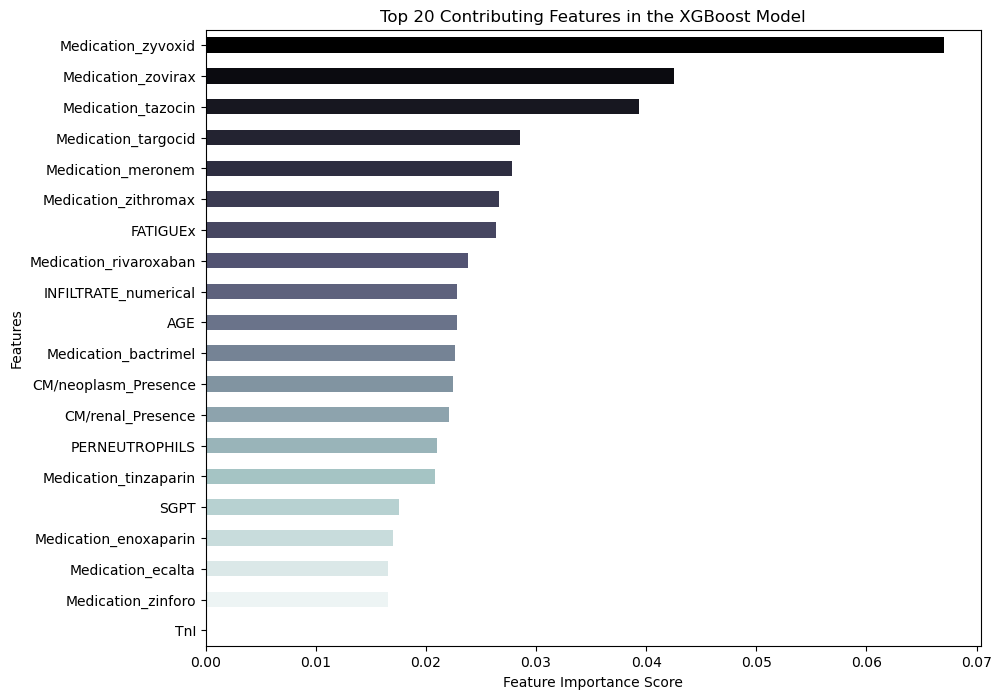

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# Access feature importance from the model
feature_importances = optimized_xgb.feature_importances_

# Create a pandas series to hold the feature importances and their corresponding feature names
importances = pd.Series(feature_importances, index=X.columns)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)

# Select the top 20 features
top20_importances = sorted_importances[:20]

# Plotting
plt.figure(figsize=(10, 8))
bone_colors = plt.cm.bone(np.linspace(0, 1, 20))
top20_importances.plot(kind='barh', color=bone_colors)
plt.title('Top 20 Contributing Features in the XGBoost Model')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


## Logistic regression Parapameters

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.1, 0.2],  # Example range, adjust based on your needs
    'penalty': ['l1', 'l2'],  # Regularization types
    'solver': ['liblinear', 'saga']  # Solvers that support L1 penalty
}

# Initialize the GridSearchCV object for Logistic Regression with F1 scoring
lr_grid = GridSearchCV(estimator=LogisticRegression(random_state=42, max_iter=50000), 
                       param_grid=param_grid_lr, 
                       cv=10, 
                       verbose=2, 
                       n_jobs=-1,
                       scoring=make_scorer(f1_score, average='weighted'))  # Use weighted F1 score
# Fit the grid search to the data
lr_grid.fit(X_train_smote, y_train_smote)
# Extract best parameters and best score for Logistic Regression
best_params_lr = lr_grid.best_params_
best_score_lr = lr_grid.best_score_

# Output the best parameters and best F1 score for Logistic Regression
print("Best parameters for Logistic Regression:", best_params_lr)
print("Best F1 score for Logistic Regression:", best_score_lr)


Fitting 10 folds for each of 8 candidates, totalling 80 fits


KeyboardInterrupt: 

Accuracy: 0.7216981132075472
Precision: 0.7490315360996455
Recall: 0.7216981132075472
F1 Score: 0.7317806603773584


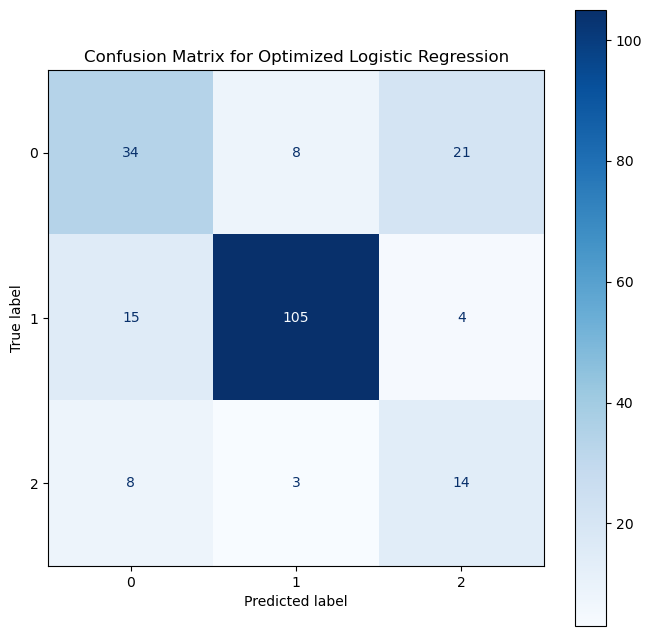

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
'''Best parameters for Logistic Regression: {'C': 5, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 score for Logistic Regression: 0.9157835919251708'''
# Best parameters for Logistic Regression (replace with your actual best parameters)
best_params_lr = {
    'C': 3,  
    'penalty': 'l2',  
    'solver': 'saga' 
}

# Correctly initialized Logistic Regression model with the best parameters
optimized_lr = LogisticRegression(
    C=best_params_lr['C'],
    penalty=best_params_lr['penalty'],
    solver=best_params_lr['solver'],
    max_iter=50000,  
    random_state=42
)

# Fit the model to the SMOTE-enhanced training data
optimized_lr.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred_lr = optimized_lr.predict(X_test_scaled)  #

# Calculate metrics
optimized_accuracy_lr = accuracy_score(y_test, y_pred_lr)
optimized_precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
optimized_recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
optimized_f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# Calculate and display the confusion matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

print(f"Accuracy: {optimized_accuracy_lr}")
print(f"Precision: {optimized_precision_lr}")
print(f"Recall: {optimized_recall_lr}")
print(f"F1 Score: {optimized_f1_lr}")

# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp_lr = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lr)
disp_lr.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized Logistic Regression')
plt.show()


Accuracy: 0.7216981132075472
Precision for each class: [0.59649123 0.90517241 0.35897436]
Recall for each class: [0.53968254 0.84677419 0.56      ]
F1 Score for each class: [0.56666667 0.875      0.4375    ]


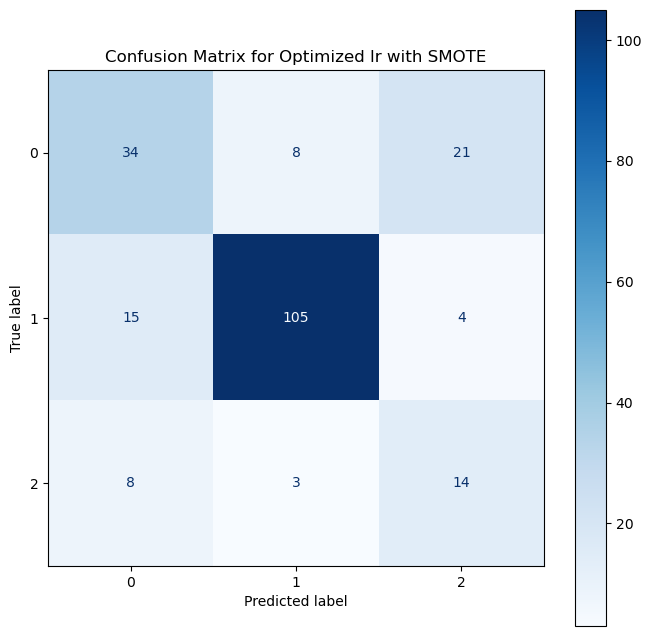

In [54]:
# Calculate evaluation metrics for each class
optimized_accuracy_lr = accuracy_score(y_test, y_pred_lr)
optimized_precision_lr = precision_score(y_test, y_pred_lr, average=None, zero_division=0)  # Scores for each class
optimized_recall_lr = recall_score(y_test, y_pred_lr, average=None, zero_division=0)  # Scores for each class
optimized_f1_lr = f1_score(y_test, y_pred_lr, average=None, zero_division=0)  # Scores for each class

# Print the metrics for each class
print(f"Accuracy: {optimized_accuracy_lr}")
print("Precision for each class:", optimized_precision_lr)
print("Recall for each class:", optimized_recall_lr)
print("F1 Score for each class:", optimized_f1_lr)

# Calculate and display the confusion matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as necessary
disp_lr = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lr)
disp_lr.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Optimized lr with SMOTE')
plt.show()


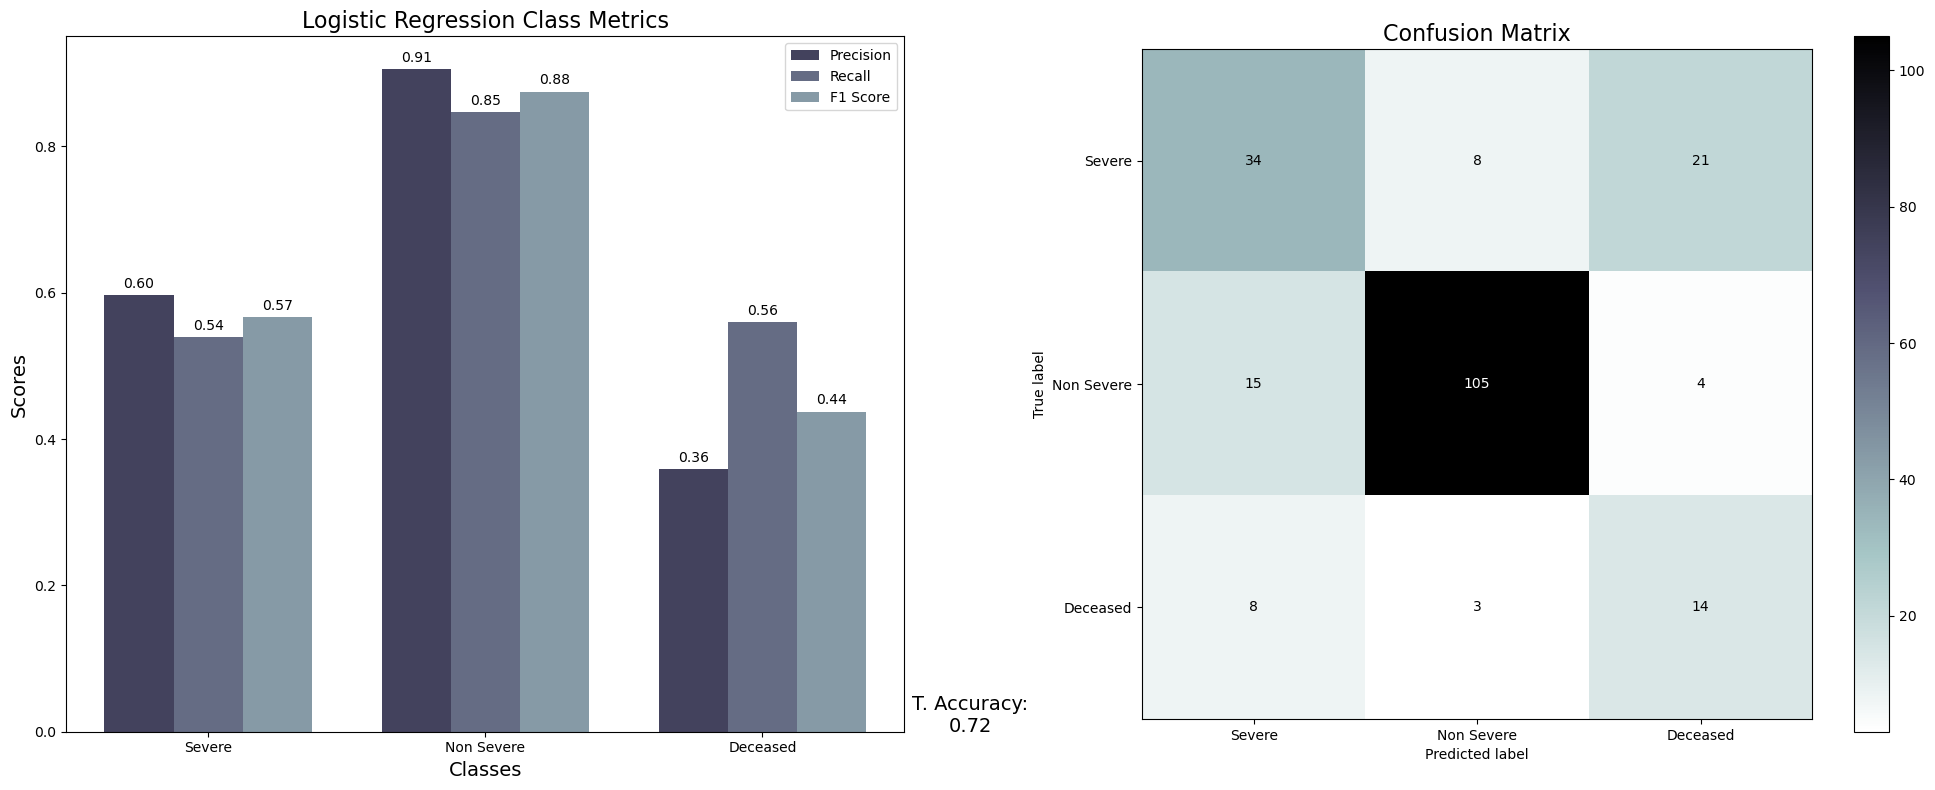

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming class_labels and lr metrics are already defined

# Setting up the subplot layout
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Two plots side by side
class_labels = ['Severe', 'Non Severe', 'Deceased']
# Metrics visualization (on the left)
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3))  # Generate bone palette for three metrics

# Plotting precision, recall, and F1-score for each class using lr metrics
bar_width = 0.25
index = np.arange(len(class_labels))
axes[0].bar(index, optimized_precision_lr, bar_width, color=bone_palette[0], label='Precision')
axes[0].bar(index + bar_width, optimized_recall_lr, bar_width, color=bone_palette[1], label='Recall')
axes[0].bar(index + 2 * bar_width, optimized_f1_lr, bar_width, color=bone_palette[2], label='F1 Score')

# Adding details to the lr metrics plot
axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Scores', fontsize=14)
axes[0].set_title('Logistic Regression Class Metrics', fontsize=16)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# Annotate the bars with the actual values and add overall accuracy for lr
for i in index:
    axes[0].text(i, optimized_precision_lr[i] + 0.01, f'{optimized_precision_lr[i]:.2f}', ha='center')
    axes[0].text(i + bar_width, optimized_recall_lr[i] + 0.01, f'{optimized_recall_lr[i]:.2f}', ha='center')
    axes[0].text(i + 2 * bar_width, optimized_f1_lr[i] + 0.01, f'{optimized_f1_lr[i]:.2f}', ha='center')

# Adding the overall accuracy for lr
axes[0].text(len(class_labels), 0, f'T. Accuracy:\n{optimized_accuracy_lr:.2f}', fontsize=14, ha='center')

# Confusion matrix visualization (on the right) for lr
conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix_lr, display_labels=class_labels)
conf_matrix_disp.plot(cmap=plt.cm.bone_r, ax=axes[1], colorbar=True)
axes[1].set_title('Confusion Matrix', fontsize=16)

plt.tight_layout()
plt.show()


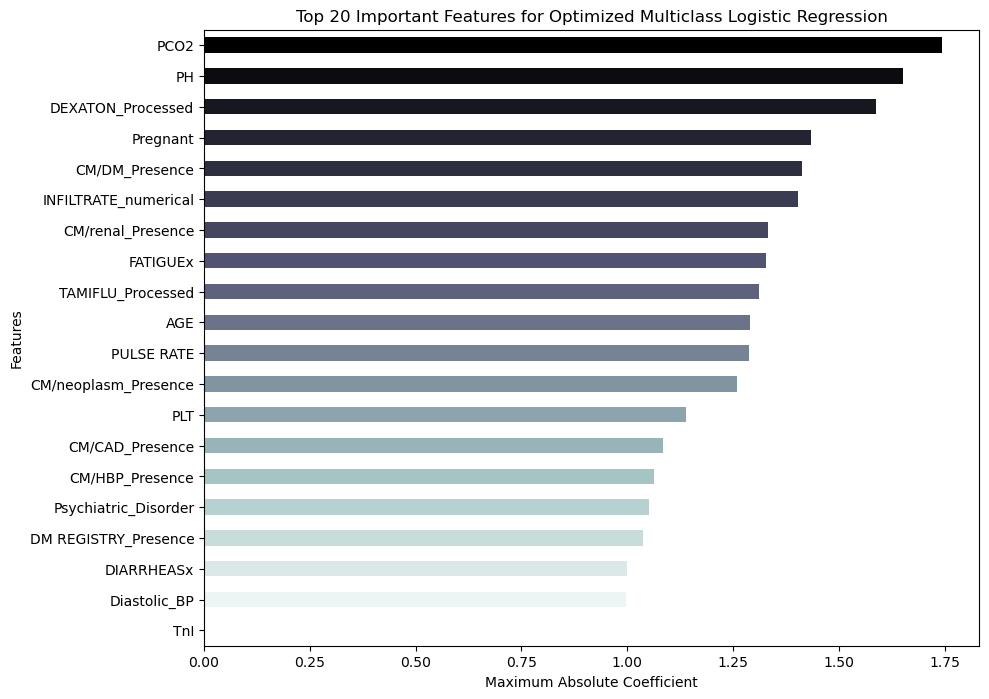

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the coefficients from the Logistic Regression model
# 'optimized_lr.coef_' will have shape (n_classes, n_features)
coefficients = optimized_lr.coef_

# Create a DataFrame for easier manipulation, assuming 'X_train' holds the feature names
feature_names = X_train.columns
coef_df = pd.DataFrame(coefficients.T, index=feature_names, columns=['Class1', 'Class2', 'Class3'])

# Aggregate the importance by taking the maximum of the absolute values across classes for each feature
# You can change this to .mean() if you prefer average importance
feature_importance = coef_df.abs().max(axis=1)

# Sort features by their importance
sorted_features = feature_importance.sort_values(ascending=False)

# Select the top 20 features
top20_features = sorted_features[:20]

# Plotting
plt.figure(figsize=(10, 8))
bone_colors = plt.cm.bone(np.linspace(0, 1, 20))
top20_features.plot(kind='barh', color=bone_colors)
plt.title('Top 20 Important Features for Optimized Multiclass Logistic Regression')
plt.xlabel('Maximum Absolute Coefficient')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


Training Meta-learners:   0%|          | 0/5 [00:00<?, ?it/s]


Training Stacked Model with lr as meta-learner...


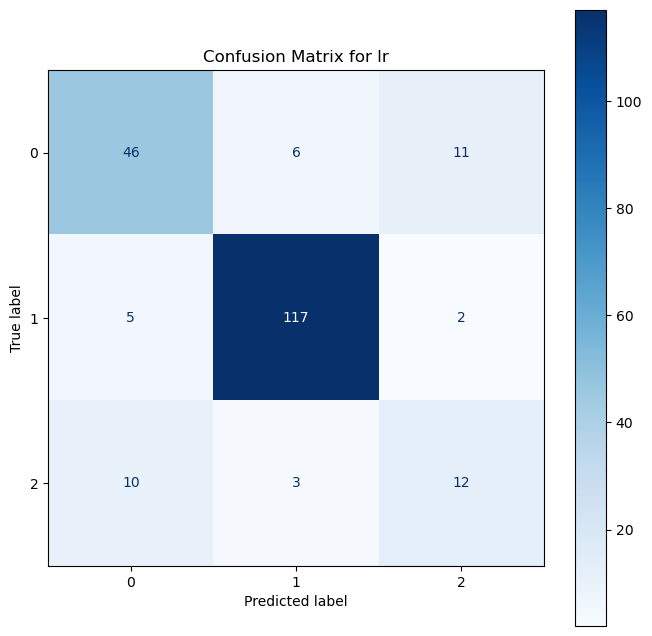

Training Meta-learners:  20%|██        | 1/5 [00:34<02:19, 34.88s/it]


Training Stacked Model with xgb as meta-learner...


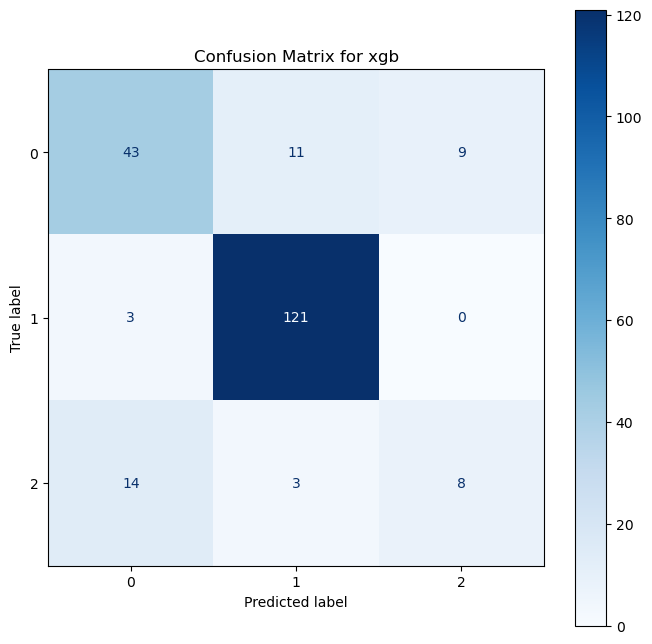

Training Meta-learners:  40%|████      | 2/5 [01:11<01:47, 35.86s/it]


Training Stacked Model with Random Forest as meta-learner...


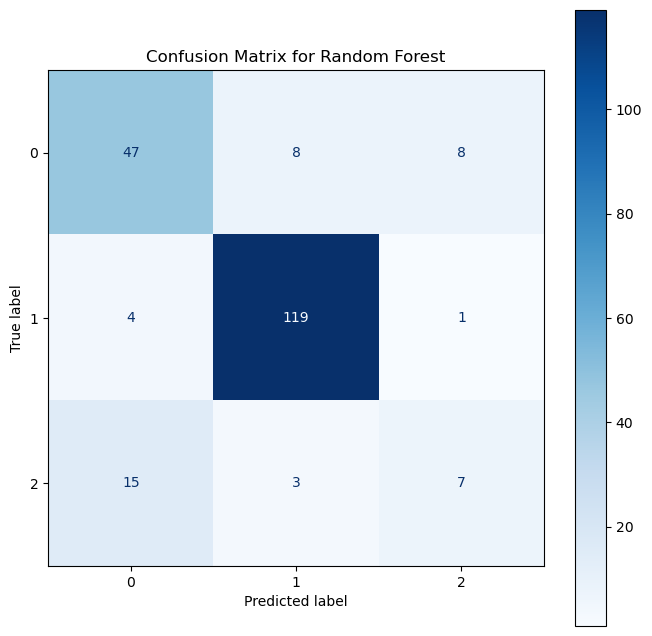

Training Meta-learners:  60%|██████    | 3/5 [01:49<01:14, 37.09s/it]


Training Stacked Model with Gradient Boosting as meta-learner...


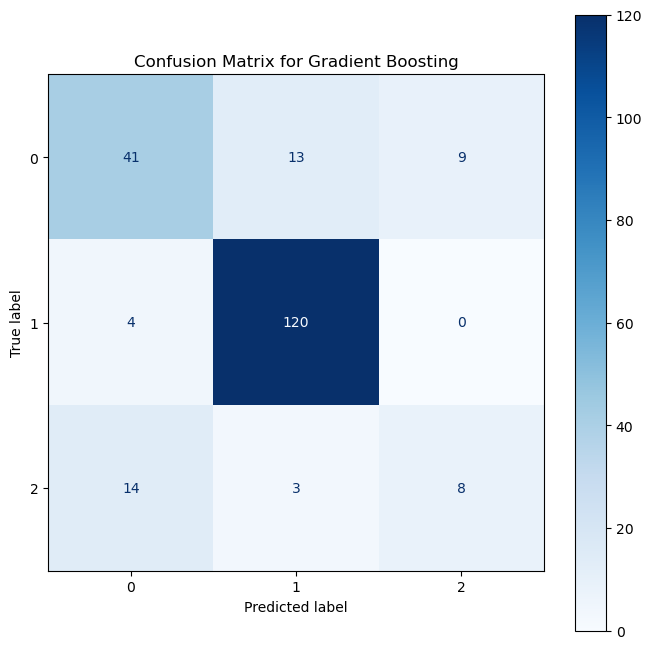

Training Meta-learners:  80%|████████  | 4/5 [02:27<00:37, 37.39s/it]


Training Stacked Model with svm as meta-learner...


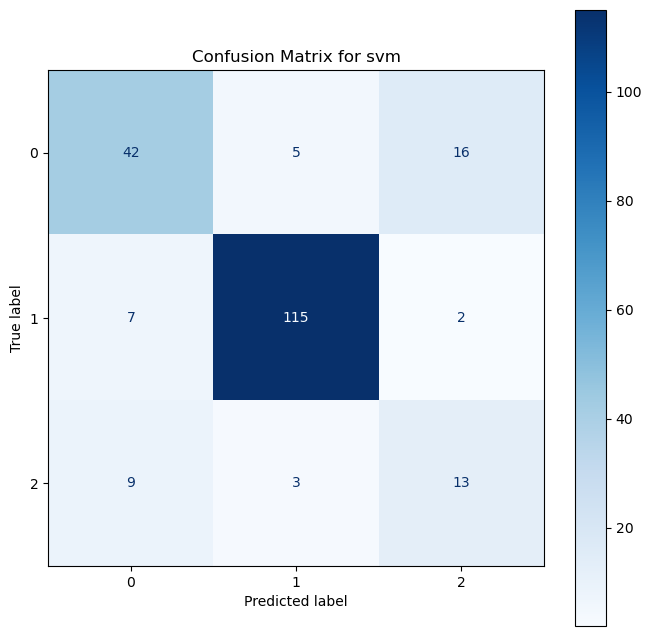

Training Meta-learners: 100%|██████████| 5/5 [03:05<00:00, 37.10s/it]


lr Meta-learner Results:
Accuracy: 0.8255
Precision: 0.8238
Recall: 0.8255
F1 Score: 0.8246

xgb Meta-learner Results:
Accuracy: 0.8113
Precision: 0.7927
Recall: 0.8113
F1 Score: 0.7992

Random Forest Meta-learner Results:
Accuracy: 0.8160
Precision: 0.7986
Recall: 0.8160
F1 Score: 0.8049

Gradient Boosting Meta-learner Results:
Accuracy: 0.7972
Precision: 0.7781
Recall: 0.7972
F1 Score: 0.7846

svm Meta-learner Results:
Accuracy: 0.8019
Precision: 0.8115
Recall: 0.8019
F1 Score: 0.8057


In [163]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tqdm import tqdm 

# List of meta-learners to evaluate
meta_learners = [
    ('lr', optimized_lr),
    ('xgb', optimized_xgb),
    ('Random Forest',optimized_rf),
    ('Gradient Boosting', optimized_gb),
    ('svm', optimized_svm)
]

# Define your base learners
base_learners = [
    ('lr', optimized_lr),
    ('rf', optimized_rf),
    ('gb', optimized_gb),
    ('svc', optimized_svm),
    ('xgb', optimized_xgb)
]

# Dictionary to hold the results for each meta-learner
results = {}
# Dictionary to hold the confusion matrices for each meta-learner
conf_matrices = {}

# Loop through each meta-learner, create a stacking classifier, fit, predict, score, and plot confusion matrix
for name, meta_learner in tqdm(meta_learners, desc="Training Meta-learners"):
    print(f"\nTraining Stacked Model with {name} as meta-learner...")
    stacked_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=20, n_jobs=-1)
    stacked_model.fit(X_train_smote, y_train_smote)
    y_pred_stacked = stacked_model.predict(X_test_scaled)
    
    # Metrics
    stacked_accuracy = accuracy_score(y_test, y_pred_stacked)
    stacked_precision = precision_score(y_test, y_pred_stacked, average='weighted', zero_division=0)
    stacked_recall = recall_score(y_test, y_pred_stacked, average='weighted', zero_division=0)
    stacked_f1 = f1_score(y_test, y_pred_stacked, average='weighted', zero_division=0)
    results[name] = {'Accuracy': stacked_accuracy, 'Precision': stacked_precision, 'Recall': stacked_recall, 'F1 Score': stacked_f1}
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred_stacked)
    conf_matrices[name] = conf_matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    
    # Visualization
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(f'Confusion Matrix for {name}')
    plt.show()

for meta_learner, metrics in results.items():
    print(f"\n{meta_learner} Meta-learner Results:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


In [58]:

# Calculate metrics for each model
metrics = {}
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'XGBoost']
predictions = [y_pred_lr, y_pred_rf, y_pred_gb,  y_pred_svm, y_pred_xgb]

for model, y_pred in zip(models, predictions):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    metrics[model] = [accuracy, precision, recall, f1]


In [59]:
import matplotlib.pyplot as plt
import numpy as np


# Assuming 'models' and 'accuracies' are defined
models = ['lr', 'rf', 'gb', 'svc', 'xgb']  # Example model names
accuracies = [metrics[model][0] for model in models]  # Example accuracy values

# Set up the figure for a horizontal bar chart
plt.figure(figsize=(10, 5))
ax = plt.subplot()

# Define a professional, muted color palette
colors = ['#34495e', '#7f8c8d', '#95a5a6', '#bdc3c7', '#e74c3c']  # Dark and grey shades with a touch of color

# Plot horizontal bars
y_positions = np.arange(len(models))
bars = ax.barh(y_positions, accuracies, color=colors, edgecolor='black', linewidth=1, alpha=0.7)

# Highlight the best performer by adjusting its properties
best_idx = np.argmax(accuracies)
bars[best_idx].set_color('#2ecc71')  # A distinct, yet professional color for the best model
bars[best_idx].set_edgecolor('black')

# Add text annotations for accuracy percentages
for bar in bars:
    width = bar.get_width()
    ax.text(width - 0.05, bar.get_y() + bar.get_height() / 2, f'{width:.2%}', 
            ha='right', va='center', color='white', fontweight='bold', fontsize=10)

# Aesthetic improvements for a professional look
ax.set_yticks(y_positions)
ax.set_yticklabels(models, fontsize=12)
ax.invert_yaxis()  # Invert so highest values are on top
ax.set_xlabel('Accuracy', fontsize=14)
ax.set_xlim(0, max(accuracies) + 0.1)  # Add some padding to the maximum accuracy
ax.set_title('Comparison of Model Accuracies', fontsize=16, fontweight='bold')
ax.spines['top'].set_visible(False)  # Clean up the plot borders
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.5, which='major', axis='x')  # Only x-axis gridlines for readability
ax.set_facecolor('#ecf0f1')  # Light grey background for a soft, professional look
ax.tick_params(axis='both', which='both', length=0)  # Remove tick marks for cleaner aesthetics

plt.tight_layout()
plt.show()


KeyError: 'lr'

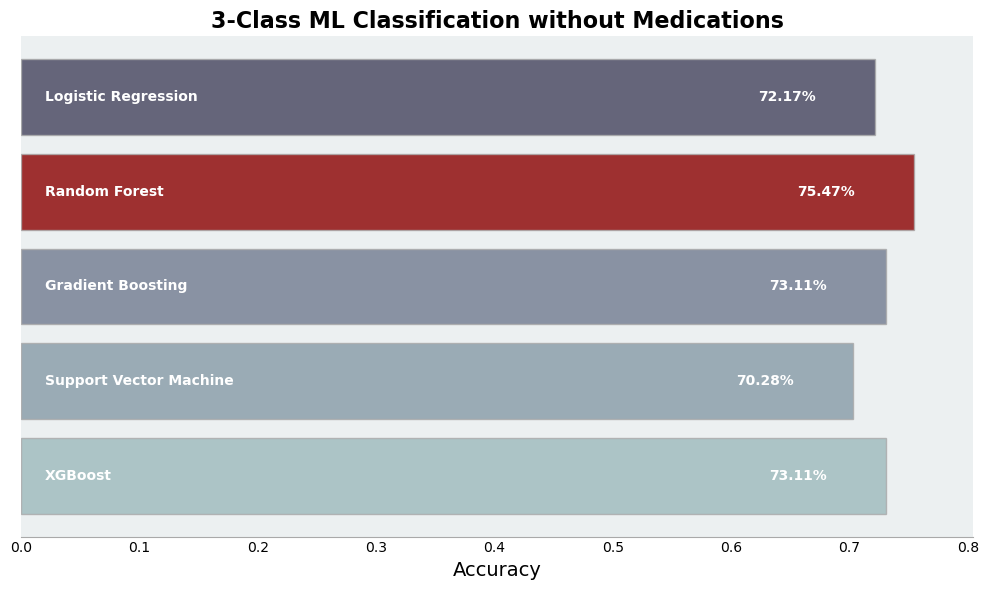

In [61]:
# Assuming 'models' and 'accuracies' are defined
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'XGBoost']  
accuracies = [metrics[model][0] for model in models] 

# Set up the figure for a horizontal bar chart
plt.figure(figsize=(10, 6))
ax = plt.subplot()

# Define a professional, muted color palette using 'bone'
colors = plt.cm.bone(np.linspace(0.3, 0.7, len(models)))

# Plot horizontal bars
y_positions = np.arange(len(models))
bars = ax.barh(y_positions, accuracies, color=colors, edgecolor='darkgrey', linewidth=1, alpha=0.8)

# Highlight the best performer by adjusting its properties
best_idx = np.argmax(accuracies)
bars[best_idx].set_color('#8B0000') 
bars[best_idx].set_edgecolor('darkgrey')

# Add text annotations for accuracy percentages inside the bars
for bar, accuracy in zip(bars, accuracies):
    ax.text(bar.get_width() - 0.05, bar.get_y() + bar.get_height() / 2, f'{accuracy:.2%}', 
            ha='right', va='center', color='white', fontweight='bold', fontsize=10)

# Add text annotations for the full names of each algorithm inside the bars
for bar, model_name in zip(bars, models):
    ax.text(0.02, bar.get_y() + bar.get_height() / 2, model_name, 
            ha='left', va='center', color='white', fontweight='bold', fontsize=10)

# Aesthetic improvements
ax.set_yticks([])  
ax.invert_yaxis()  
ax.set_xlabel('Accuracy', fontsize=14)
ax.set_xlim(0, max(accuracies) + 0.05)  
ax.set_title('3-Class ML Classification without Medications', fontsize=16, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
ax.spines['bottom'].set_color('darkgrey')
ax.set_facecolor('#ecf0f1')  
ax.tick_params(axis='both', which='both', length=0)  

plt.tight_layout()
plt.show()


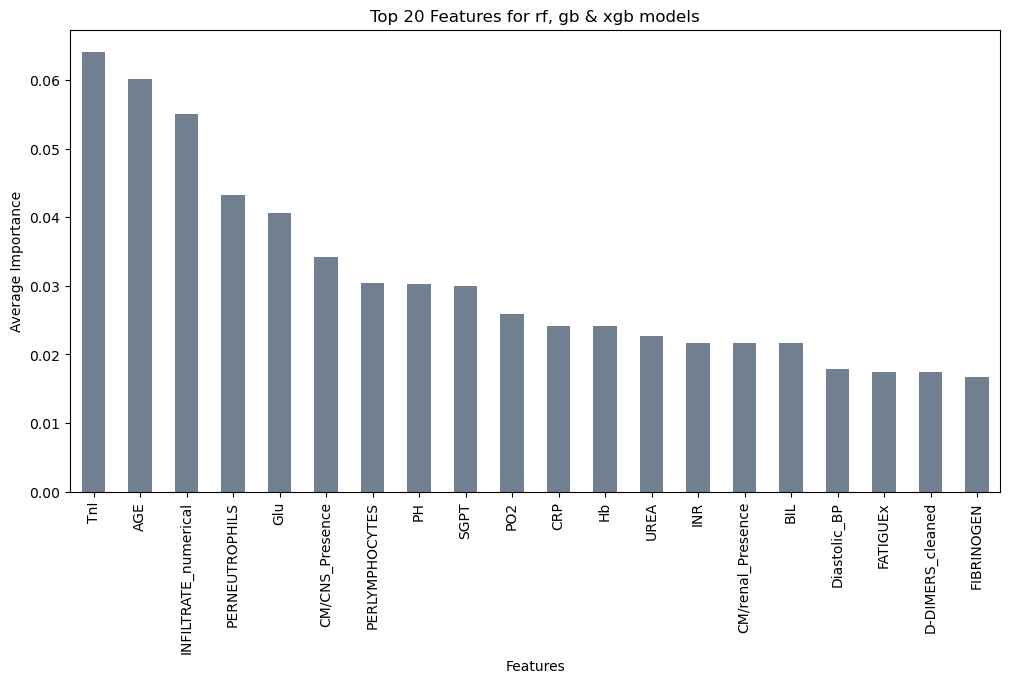

In [62]:
# Assuming X_train has feature names
feature_names = X_train.columns

# Placeholder dictionaries for feature importances from each model
feature_importances = {
    'rf': optimized_rf.feature_importances_,
    'gb': optimized_gb.feature_importances_,
    'xgb': optimized_xgb.feature_importances_
}

# Initialize a DataFrame to hold aggregated feature importances
importance_df = pd.DataFrame(index=feature_names)

# Fill the DataFrame with feature importances from each model
for model_name, importances in feature_importances.items():
    importance_df[model_name] = importances

# Calculate average importance for each feature
importance_df['average'] = importance_df.mean(axis=1)

# Sort features based on average importance
sorted_features = importance_df.sort_values(by='average', ascending=False)

# Visualize the top 20 features 
top_features = sorted_features.head(20)
top_features['average'].plot(kind='bar', figsize=(12, 6), color='slategray')
plt.title('Top 20 Features for rf, gb & xgb models')
plt.ylabel('Average Importance')
plt.xlabel('Features')
plt.show()


In [63]:
import shap
shap.initjs()
# Initialize SHAP explainers
explainers = {
    'Random Forest': shap.TreeExplainer(optimized_rf),
    'XGBoost': shap.TreeExplainer(optimized_xgb)
}

# Calculate SHAP values for a sample of the test set to save computation time
X_sample = X_test.sample(100, random_state=42, replace=True)  

shap_values = {
    name: explainer.shap_values(X_sample)
    for name, explainer in explainers.items()
}


Model: Random Forest


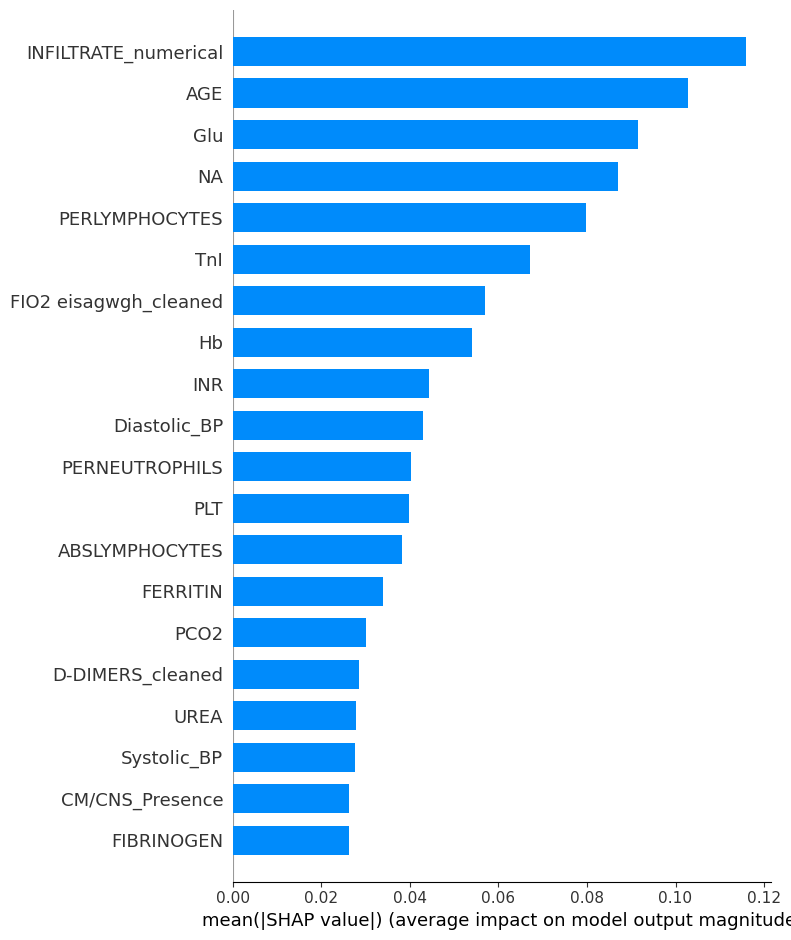

Model: XGBoost


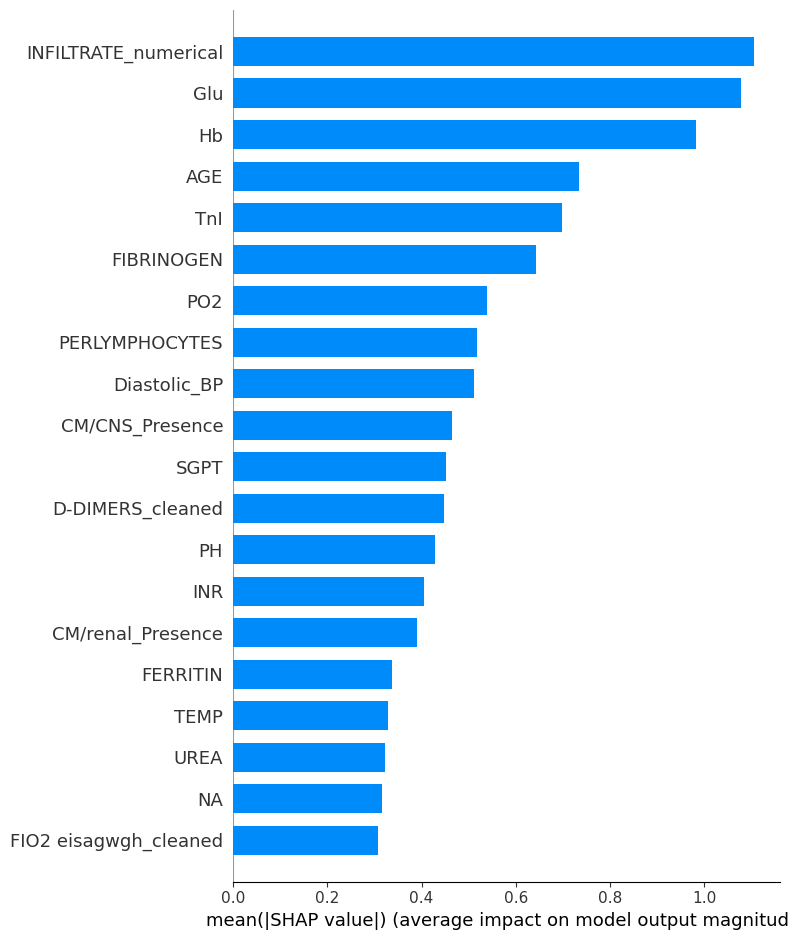

In [64]:
# Visualization
for model_name, model_shap_values in shap_values.items():
    print(f"Model: {model_name}")
    # Check if SHAP values are in multi-class format (list of arrays)
    if isinstance(model_shap_values, list):  # Handling multi-class scenarios
        # Aggregate SHAP values across all classes for each sample
        values_aggregated = np.sum(np.abs(model_shap_values), axis=0)  # Sum across classes, maintaining the sample-feature structure
    else:
        # Use directly if already in the correct format
        values_aggregated = model_shap_values
    
    # Ensure we have a 2D array for the summary plot
    if len(values_aggregated.shape) == 1:
        # This means SHAP values are somehow still a vector; try reshaping or debugging how they were aggregated
        continue  # Or handle the error appropriately
    
    # Now plotting with the aggregated (summed across classes) SHAP values
    shap.summary_plot(values_aggregated, X_sample, plot_type="bar", feature_names=X_sample.columns, max_display=20)


Model: Random Forest


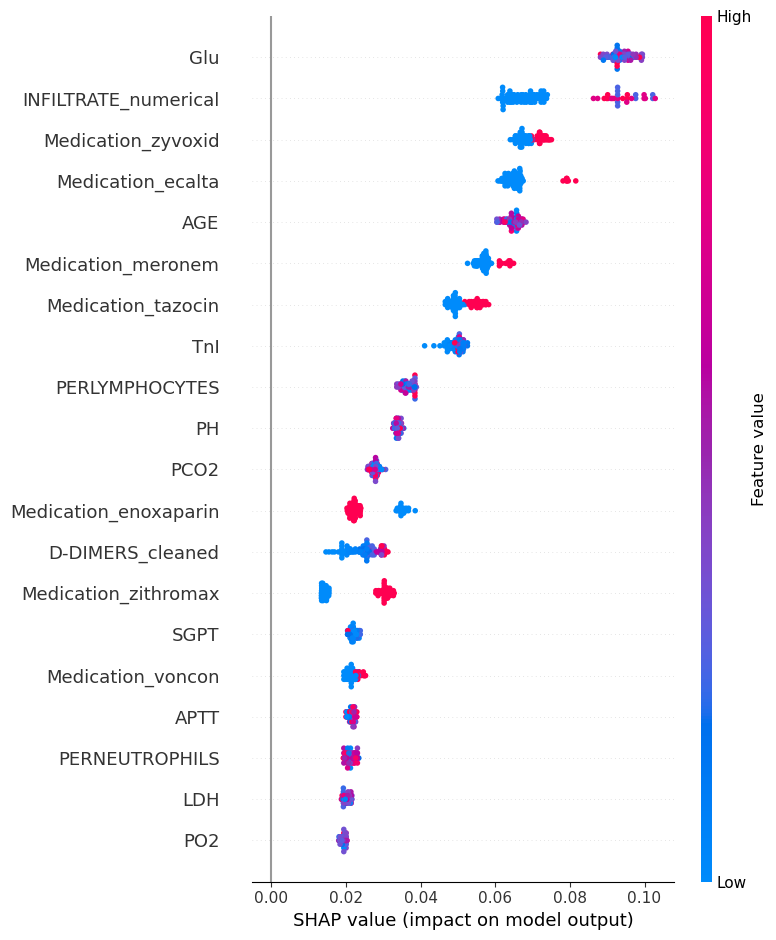

Model: XGBoost


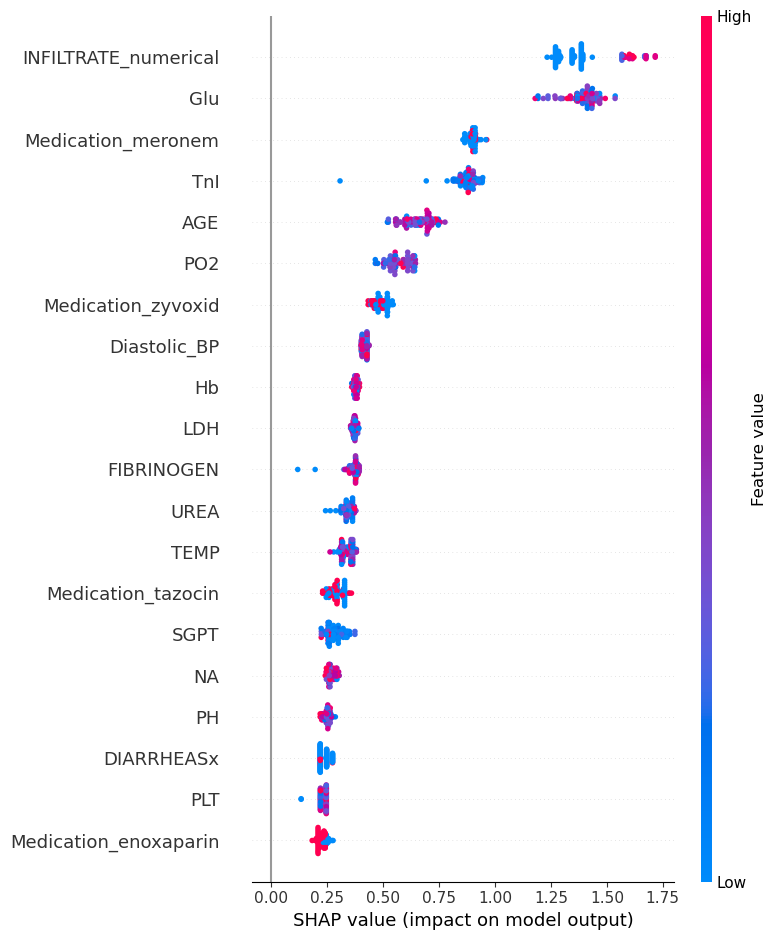

In [169]:
for model_name, model_shap_values in shap_values.items():
    print(f"Model: {model_name}")
    if isinstance(model_shap_values, list):  # For multi-class models
        # Summing SHAP values across all classes (for simplicity here, modify as needed)
        summed_shap = np.sum([np.abs(m) for m in model_shap_values], axis=0)
        shap.summary_plot(summed_shap, X_sample, feature_names=X_sample.columns)
    else:  # For binary classification or regression
        shap.summary_plot(model_shap_values, X_sample, feature_names=X_sample.columns)


Model: Random Forest - Dependence Plot for Medication_tazocin


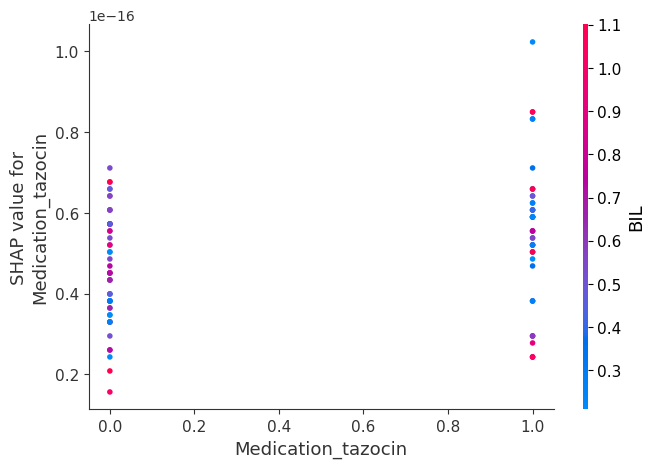

Model: XGBoost - Dependence Plot for Medication_tazocin


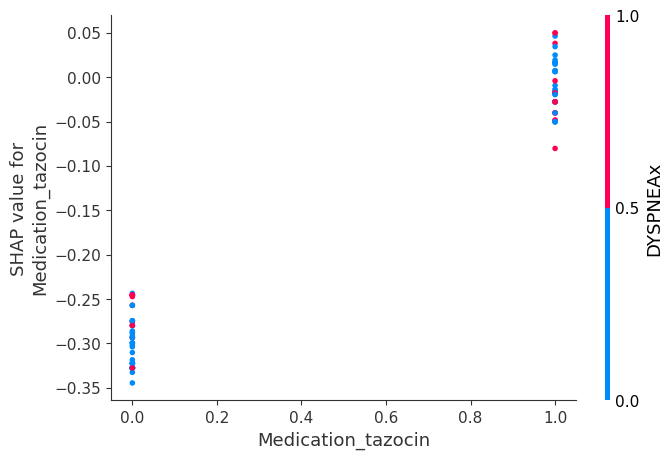

In [170]:
# Select a feature for the dependence plot,
selected_feature = top_features.index[0] 

for model_name, model_shap_values in shap_values.items():
    print(f"Model: {model_name} - Dependence Plot for {selected_feature}")
    if isinstance(model_shap_values, list):
        # For simplicity, use SHAP values from the first class or summed (customize as needed)
        shap.dependence_plot(selected_feature, np.sum(model_shap_values, axis=0), X_sample, feature_names=X_sample.columns)
    else:
        shap.dependence_plot(selected_feature, model_shap_values, X_sample, feature_names=X_sample.columns)


Model: Random Forest - Force Plot for instance 0


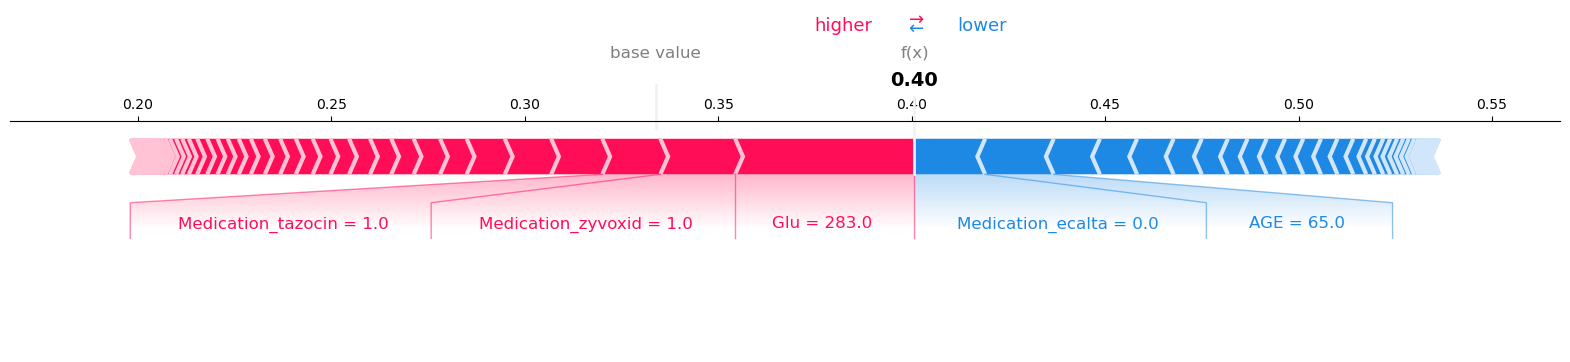

Model: Random Forest - Force Plot for instance 1


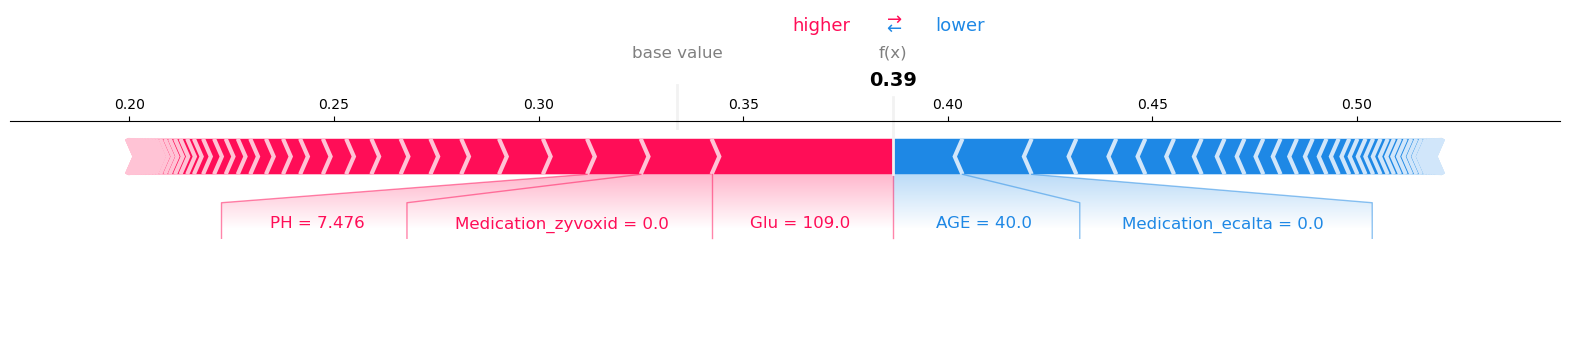

Model: Random Forest - Force Plot for instance 2


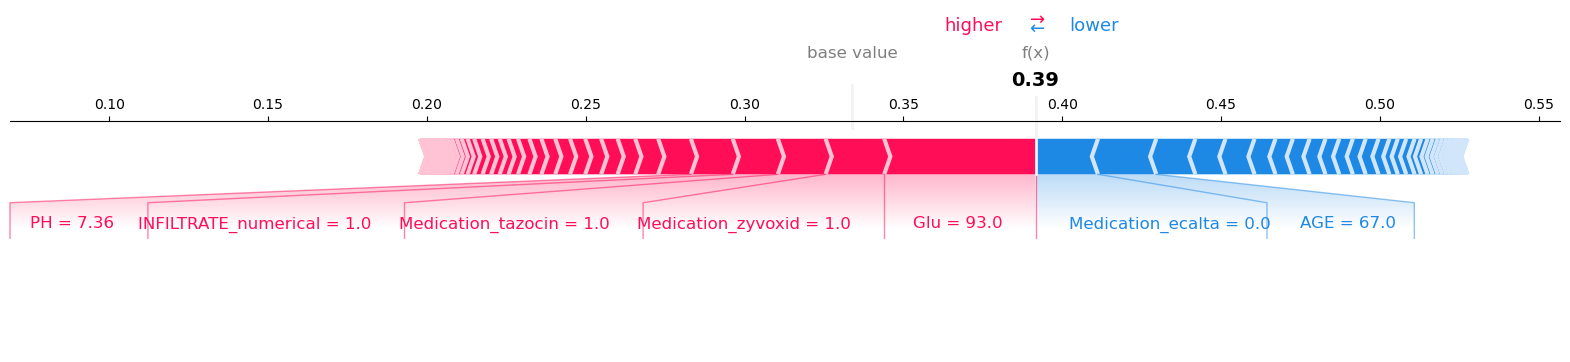

Model: XGBoost - Force Plot for instance 0


TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[0]).

In [171]:
for model_name, model_shap_values in shap_values.items():
    # Retrieve the correct explainer for the current model
    current_explainer = explainers[model_name]

    # Display force plots for a few individual predictions
    for i in range(min(3, len(X_sample))):  # Adjust the range as needed, ensure it does not exceed sample size
        print(f"Model: {model_name} - Force Plot for instance {i}")
        if isinstance(model_shap_values, list):
            # Check if current_explainer.expected_value is a list or scalar
            expected_value = current_explainer.expected_value[0] if isinstance(current_explainer.expected_value, np.ndarray) else current_explainer.expected_value
            # Generate the force plot
            shap.force_plot(expected_value, model_shap_values[0][i], X_sample.iloc[i], matplotlib=True)
        else:
            # For binary classification or regression, expected_value is likely a scalar
            expected_value = current_explainer.expected_value if not isinstance(current_explainer.expected_value, np.ndarray) else current_explainer.expected_value[0]
            # Generate the force plot
            shap.force_plot(expected_value, model_shap_values[i], X_sample.iloc[i], matplotlib=True)


In [ ]:
'''# Exporting progress 
file_path_dataset1 = '/Users/michael/Thesis project/Analysis/test.xlsx' 
data_clustering_final.to_excel(file_path_dataset1, index=False)'''
